In [1]:
%matplotlib inline
import sys
import numpy
import numpy as np
from matplotlib import pyplot as plt
from amuse.units import (units, constants)
from amuse.ext.orbital_elements import new_binary_from_orbital_elements
from amuse.ext.orbital_elements import orbital_elements_from_binary
from amuse.ext.protodisk import ProtoPlanetaryDisk
from amuse.ext.composition_methods import *
from amuse.lab import Particles
from amuse.lab import nbody_system
from amuse.lab import new_powerlaw_mass_distribution
from amuse.plot import scatter
from amuse.community.ph4.interface import ph4
from amuse.community.fi.interface import Fi
from amuse.couple import bridge
# from amuse.community.huayno.interface import Huayno

In [2]:
def ProgressBar(total, progress):
    barLength, status = 20, ""
    progress = float(progress) / float(total)
    if progress >= 1.:
        progress, status = 1, "\r\n"
    block = int(round(barLength * progress))
    text = "\r[{}] {:.0f}% {}".format(
        "#" * block + "-" * (barLength - block), round(progress * 100, 0),
        status)
    sys.stdout.write(text)
    sys.stdout.flush()

In [3]:
def orbital_period(Mtot, a):
    return (((4 * numpy.pi**2) * a**3)/(constants.G * Mtot)).sqrt()

# def relative_orbital_velocity(distance, mass=SMBH.mass):
#     return (constants.G*mass/distance).sqrt()

def plot():
    plt.figure(figsize=(8,6))
    scatter(BHdisk.x.value_in(units.pc), BHdisk.y.value_in(units.pc), s=10, alpha=0.8, c='blue', label='BH')
    scatter(SMBH.x.value_in(units.pc), SMBH.y.value_in(units.pc), s=50, c='r', label='SMBH')
    plt.annotate(str(round(model_time.value_in(units.Myr)))+" Myr", xy=(6.9, 9), xytext=(6.9, 9), 
                 weight='heavy', bbox=dict(boxstyle='round,pad=0.5', fc='yellow', ec='k', lw=1, alpha=0.5))
    #plt.title("Evolved to t = "+str(round(model_time.value_in(units.Myr)))+" Myr")
    plt.axis('square')
    plt.xlim([-r, r])
    plt.ylim([-r, r])
    

# Distance to (0,0)
def dist(body):
    return (body.x**2+body.y**2+body.z**2).sqrt()

# Define collision detection
def merge_two_stars(bodies, particles_in_encounter):
    com_pos = particles_in_encounter.center_of_mass()
    com_vel = particles_in_encounter.center_of_mass_velocity()
    d = (particles_in_encounter[0].position - particles_in_encounter[1].position)
    v = (particles_in_encounter[0].velocity - particles_in_encounter[1].velocity)
    print("Two BHs", particles_in_encounter.name, particles_in_encounter.mass.in_(units.MSun),
          "collided with d=", d.length().in_(units.au))
    
    particles_in_encounter[np.argmax(particles_in_encounter.mass)].mass = particles_in_encounter.total_mass()
    particles_in_encounter[np.argmax(particles_in_encounter.mass)].position = com_pos
    particles_in_encounter[np.argmax(particles_in_encounter.mass)].velocity = com_vel
    particles_in_encounter[np.argmax(particles_in_encounter.mass)].radius = particles_in_encounter.radius.sum()
    bodies.remove_particle(particles_in_encounter[np.argmin(particles_in_encounter.mass)])
    
#     new_particle=Particles(1)
#     new_particle.mass = particles_in_encounter.total_mass()
#     new_particle.name = particles_in_encounter[np.argmax(particles_in_encounter.mass)].name
#     new_particle.position = com_pos
#     new_particle.velocity = com_vel
#     new_particle.radius = particles_in_encounter.radius.sum()
#     bodies.add_particles(new_particle)
#     bodies.remove_particles(particles_in_encounter)
    
def resolve_collision(collision_detection, gravity, bodies):
    if collision_detection.is_set():
        print("Well, we have an actual collision between two or more BHs.")
        print("This happened at time=", gravity.model_time.in_(units.Myr))
        for ci in range(len(collision_detection.particles(0))): 
            encountering_particles = Particles(particles=[collision_detection.particles(0)[ci],
                                                          collision_detection.particles(1)[ci]])
            colliding_BHs = encountering_particles.get_intersecting_subset_in(bodies)
            merge_two_stars(bodies, colliding_BHs)
            bodies.synchronize_to(gravity.particles)

            
            
# Binaries detection
def get_binaries(particles,hardness=0.5,G=constants.G):
    n=len(particles)
    total_Ek=(0.5*particles.mass*(particles.vx**2+particles.vy**2+particles.vz**2)).sum()
    average_Ek=total_Ek/particles.mass.sum()
    max_mass=particles.mass.amax()
    limitE=hardness*average_Ek
    
    a=numpy.argsort(particles.x.number)
    a=np.delete(a,particles[a].name=="SMBH")
    n=len(a)

    binaries=[]

    for i in range(0, n-1):
        j=i+1
        while j<n and j<i+10 and (particles.x[a[j]]-particles.x[a[i]])<2*G*max_mass/limitE:
            r2=(particles.x[a[j]]-particles.x[a[i]])**2+ \
               (particles.y[a[j]]-particles.y[a[i]])**2+ \
               (particles.z[a[j]]-particles.z[a[i]])**2 
            v2=(particles.vx[a[j]]-particles.vx[a[i]])**2+ \
               (particles.vy[a[j]]-particles.vy[a[i]])**2+ \
               (particles.vz[a[j]]-particles.vz[a[i]])**2 
            r=r2**0.5
            eb=G*(particles.mass[a[i]]+particles.mass[a[j]])/r-0.5*v2
            if eb > limitE:
                binary=particles[[a[i],a[j]]].copy()
                binary.hardness=eb/average_Ek
                com_pos = binary.center_of_mass()
                binary_momentum = binary.velocity * binary.mass.reshape((-1,1))
                L_b = (binary.position-com_pos).cross(binary_momentum).sum(axis=0)
                L_b = L_b.in_(units.pc*units.MSun*units.km/units.s)
                binary.thetaz = L_b[2] / L_b.length() # angle between the angular momentum and z-axis
                binaries.append(binary)
            j+=1  

    return binaries, average_Ek


def get_hardness(BBH, particles, G=constants.G):
    
    n=len(particles)
    total_Ek=(0.5*particles.mass*(particles.vx**2+particles.vy**2+particles.vz**2)).sum()
    average_Ek=total_Ek/particles.mass.sum()
    
    r2=(BBH.x[0]-BBH.x[1])**2+ \
       (BBH.y[0]-BBH.y[1])**2+ \
       (BBH.z[0]-BBH.z[1])**2 
    v2=(BBH.vx[0]-BBH.vx[1])**2+ \
       (BBH.vy[0]-BBH.vy[1])**2+ \
       (BBH.vz[0]-BBH.vz[1])**2 
    r=r2**0.5
    eb=G*(BBH.mass[0]+BBH.mass[1])/r-0.5*v2
    
    hardness = eb/average_Ek
    
    return hardness

def relative(property1, property2):
    return ((property1 - property2)**2).sum()**0.5

## Initial condition

In [4]:
# Start with Sgr A*
SMBH = Particles(1) 
SMBH.name = "SMBH"
SMBH.mass = 4.154e+6 | units.MSun
SMBH.position = (0, 0, 0) | units.pc
SMBH.velocity = (0, 0, 0) | units.kms
SMBH.radius = 2*constants.G*SMBH.mass/constants.c**2

n_BHs = 1000 # Number of stellar-mass BHs
r = 10 # (parsec) The outmost orbital radius of BHs surrounding the SMBH
model_time = 0 | units.Myr

# Make BH disk
def make_BHdisk_around_SMBH(SMBH, n_BHs=n_BHs):
    R = r|units.pc
    Ndisk = n_BHs
    Rin = 0.1
    Rout = 1
    Pinner1 = orbital_period(SMBH.mass, Rin*R)
    converter1 = nbody_system.nbody_to_si(SMBH.mass.sum(), R)
    masses = new_powerlaw_mass_distribution(Ndisk, 1.0|units.MSun, 100.0|units.MSun, -2.35) # BH masses in powerlaw
    BHdisk = ProtoPlanetaryDisk(Ndisk,
                              convert_nbody=converter1,
                              Rmin=Rin,
                              Rmax=Rout,
                              q_out=10.0,
                              discfraction=masses.sum()/SMBH.mass).result
    BHdisk.mass = masses
    BHdisk.name = np.arange(1,n_BHs+1).astype("str")
    BHdisk.radius = 2*constants.G*BHdisk.mass/constants.c**2
    BHdisk.remove_attribute_from_store('u')
#     BHdisk.move_to_center()
    return BHdisk, Pinner1, converter1

# Make gas disk
def make_gasdisk_around_SMBH(SMBH):
    R = r|units.pc
    Ndisk = 1000
    Rin = 0.1
    Rout = 1
    Pinner2 = orbital_period(SMBH.mass, Rin*R)
    Mdisk = 1e-3 * SMBH.mass
    converter2 = nbody_system.nbody_to_si(SMBH.mass.sum(), R)
    
    gasdisk = ProtoPlanetaryDisk(Ndisk,
                              convert_nbody=converter2,
                              Rmin=Rin,
                              Rmax=Rout,
                              q_out=10.0,
                              discfraction=Mdisk/SMBH.mass).result
    gasdisk.name = "gas disk"
#     gasdisk.move_to_center()
    masses = Mdisk/float(Ndisk)
    gasdisk.mass = masses
    rho = 3.0 | (units.g/units.cm**3)
    gasdisk.radius = (gasdisk.mass/(4*rho))**(1./3.)
    return gasdisk, Pinner2, converter2

gasdisk, Pinner2, converter2 = make_gasdisk_around_SMBH(SMBH)
BHdisk, Pinner1, converter1 = make_BHdisk_around_SMBH(SMBH)

# Name each BH
for i in range(n_BHs):
    BHdisk[i].name = "BH"+BHdisk[i].name
    
# Backup
SMBH0, BHdisk0, gasdisk0 = SMBH.copy(), BHdisk.copy(), gasdisk.copy()

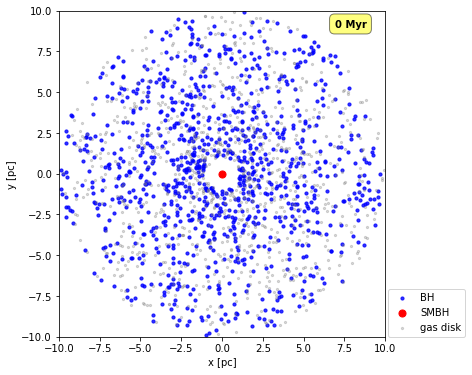

In [5]:
# The initial distribution of our objects
plot()
scatter(gasdisk.x.value_in(units.pc), gasdisk.y.value_in(units.pc), s=5, alpha=0.3, c='gray', label="gas disk")
plt.xlabel("x [pc]")
plt.ylabel("y [pc]")
plt.legend(bbox_to_anchor=(1.01, 0), loc=3, borderaxespad=0)
plt.show()

In [6]:
bodies = Particles(0)
bodies.add_particles(SMBH0)
bodies.add_particles(BHdisk0)

print(get_binaries(bodies)[1].value_in(units.km**2/units.s**2))

1.47978797909


## BBH setup

In [7]:
from amuse.ext.orbital_elements import new_binary_from_orbital_elements

N_BBH = 20

for i in np.linspace(1, 1001, num=N_BBH, endpoint=False).astype('int'):
    
    bodies_test = bodies.copy()
    
    while True:
        BBHi_1mass, BBHi_2mass = new_powerlaw_mass_distribution(2, 1.0|units.MSun, 
                                                          100.0|units.MSun, -2.35)
        np.random.seed()
        a = (np.random.rand(1)[0]*500+500) | units.au
        np.random.seed()
        e = np.random.rand(1)[0]/2
        BBHi = new_binary_from_orbital_elements(BBHi_1mass, BBHi_2mass, 
                                              a, e, G=constants.G)
        setattr(BBHi, "name", [f"BBH{i:d}_1", f"BBH{i:d}_2"])

        BBHi.position += BHdisk[BHdisk.name==f'BH{i:d}'].position
        BBHi.velocity += BHdisk[BHdisk.name==f'BH{i:d}'].velocity

        bodies_test.add_particles(BBHi)
        bodies_test = bodies_test[bodies_test.name!=f'BH{i:d}']
        hardness = get_hardness(BBHi, bodies_test)
        
        print(f'Hardness of current BBH = {hardness:.2f}.')
        if (hardness>=5) & (hardness<=10):
            bodies = bodies_test.copy()
            break
        else:
            bodies_test = bodies.copy()
            
BBH0 = bodies[n_BHs-N_BBH+1:].copy()

Hardness of current BBH = 1.19.
Hardness of current BBH = 4.85.
Hardness of current BBH = 1.93.
Hardness of current BBH = 1.60.
Hardness of current BBH = 1.94.
Hardness of current BBH = 4.43.
Hardness of current BBH = 6.24.
Hardness of current BBH = 1.31.
Hardness of current BBH = 1.17.
Hardness of current BBH = 2.71.
Hardness of current BBH = 1.94.
Hardness of current BBH = 4.17.
Hardness of current BBH = 0.94.
Hardness of current BBH = 0.90.
Hardness of current BBH = 3.49.
Hardness of current BBH = 3.24.
Hardness of current BBH = 1.27.
Hardness of current BBH = 3.31.
Hardness of current BBH = 43.28.
Hardness of current BBH = 1.21.
Hardness of current BBH = 1.11.
Hardness of current BBH = 2.10.
Hardness of current BBH = 1.53.
Hardness of current BBH = 3.22.
Hardness of current BBH = 1.11.
Hardness of current BBH = 1.68.
Hardness of current BBH = 0.88.
Hardness of current BBH = 0.91.
Hardness of current BBH = 1.38.
Hardness of current BBH = 0.98.
Hardness of current BBH = 1.61.
Hardnes

Hardness of current BBH = 4.26.
Hardness of current BBH = 2.58.
Hardness of current BBH = 1.43.
Hardness of current BBH = 1.21.
Hardness of current BBH = 7.89.
Hardness of current BBH = 1.63.
Hardness of current BBH = 2.12.
Hardness of current BBH = 3.93.
Hardness of current BBH = 2.17.
Hardness of current BBH = 0.97.
Hardness of current BBH = 1.01.
Hardness of current BBH = 1.51.
Hardness of current BBH = 2.74.
Hardness of current BBH = 2.30.
Hardness of current BBH = 7.99.
Hardness of current BBH = 0.87.
Hardness of current BBH = 0.72.
Hardness of current BBH = 1.50.
Hardness of current BBH = 1.25.
Hardness of current BBH = 5.47.
Hardness of current BBH = 0.78.
Hardness of current BBH = 1.17.
Hardness of current BBH = 2.88.
Hardness of current BBH = 1.47.
Hardness of current BBH = 1.14.
Hardness of current BBH = 4.13.
Hardness of current BBH = 2.31.
Hardness of current BBH = 1.54.
Hardness of current BBH = 1.90.
Hardness of current BBH = 14.44.
Hardness of current BBH = 1.36.
Hardnes

## Nbody simulation

In [8]:
SMBH = bodies[bodies.name=="SMBH"][0]
BHdisk = bodies[1:n_BHs-N_BBH+1]
BBH  = bodies[n_BHs-N_BBH+1:]

In [9]:
gravity = ph4(converter1, number_of_workers=32)
gravity.particles.add_particles(bodies)
channel = gravity.particles.new_channel_to(bodies)

fig_root = "figure/Nbody/"

In [10]:
# Stopping condition of collision 
stopping_condition = gravity.stopping_conditions.collision_detection
stopping_condition.enable()
collision_radius_multiplication_factor = 1e5

bodies.radius *= collision_radius_multiplication_factor

# Evolving parameters
end_time = 10 | units.Myr
model_time = 0 | units.Myr
time = [] | units.Myr
dt = 1e-2 | units.Myr
x = 0

evolve_time_list = [] | units.Myr 
# average_Ek_list = [] | units.kms**2

# binary_n = []

BBH_info = []

# bodies_x = []
# bodies_y = []

# Evolve
while(model_time<end_time):
    
    ProgressBar(end_time.value_in(units.Myr), model_time.value_in(units.Myr))
    
    gravity.evolve_model(model_time)
    resolve_collision(stopping_condition, gravity, bodies) # Collisions detection
    channel.copy()
    
#     bodies_x.append(bodies.x.value_in(units.pc)) # Restore positions for animation
#     bodies_y.append(bodies.y.value_in(units.pc))
    
    if model_time.value_in(units.Myr)>=x:
        x += 0.5

#         print("Evolved to t =", int(model_time.number), "Myr",
#               "\nBH number =", len(BHdisk))

#         plot()

#         b, average_Ek = get_binaries(bodies) # Binaries detection
        
#         if(len(b)>0):
#             print(len(b), "Binary found")
            
#             for i in range(len(b)):
#                 print("Binary", i+1, "is", b[i].name, "with hardness =", b[i].hardness[0], 
#                       "d =", (b[i].position[0] - b[i].position[1]).length().in_(units.au),
#                       "v =", (b[i].velocity[0] - b[i].velocity[1]).length().in_(units.kms),
#                      "radius =", b[i].center_of_mass().length().in_(units.pc),
#                      'and theta_z =', b[i].thetaz[0])
                
#                 binary_n.append([b[i].mass.sum().number, b[i].hardness[0], 
#                                  (b[i].position[0] - b[i].position[1]).length().in_(units.au).number,
#                                b[i].center_of_mass().length().in_(units.pc).number, b[i].thetaz[0],
#                                 (b[i].velocity[0] - b[i].velocity[1]).length().in_(units.kms).number])

#                 if b[i].hardness[0]<10:
#                     scatter([b[i].x[0].value_in(units.pc), b[i].x[1].value_in(units.pc)], 
#                                [b[i].y[0].value_in(units.pc), b[i].y[1].value_in(units.pc)], 
#                                s=10, alpha=1, c='orange')
#                 else:
#                     print("Here we have a hard binary!!!")
#                     scatter([b[i].x[0].value_in(units.pc), b[i].x[1].value_in(units.pc)], 
#                                [b[i].y[0].value_in(units.pc), b[i].y[1].value_in(units.pc)], 
#                                s=10, alpha=1, c='g')  

        
#         plt.xlabel("x [pc]")
#         plt.ylabel("y [pc]")
#         plt.legend(bbox_to_anchor=(1.01, 0), loc=3, borderaxespad=0)
#         plt.savefig(fig_root+''+str(int(model_time.value_in(units.Myr)))+'_Myr.png', dpi=150, bbox_inches='tight')
#         plt.show()
        
#         print("\n")

        evolve_time_list.append(model_time)
#         average_Ek_list.append(average_Ek)
        
        BBH_info_time = []
        for i in range(N_BBH):
            name1, name2 = BBH[i*2:i*2+2].name
            mass1, mass2 = BBH[i*2:i*2+2].mass.value_in(units.MSun)
            a = BBH[i*2].position - BBH[i*+2+1].position
            hardness = get_hardness(BBH[i*2:i*2+2], bodies)
            a = relative(BBH[i*2].position, BBH[i*2+1].position).value_in(units.au)
            r = relative(BBH[i*2:i*2+2].center_of_mass(), SMBH.position).value_in(units.pc)
            v1_v2 = relative(BBH[i*2].velocity, BBH[i*2+1].velocity).value_in(units.km/units.s)
            
            BBH_info_time.append([model_time.value_in(units.Myr), 
                                  name1, name2, mass1, mass2, hardness, a, r, v1_v2])
        
        BBH_info.append(BBH_info_time)
        
        
    model_time += dt
    

gravity.stop()

# plt.figure()
# plt.plot(evolve_time_list.value_in(units.Myr), average_Ek_list.value_in(units.kms**2))
# plt.xlabel('Evolve time [Myr]')
# plt.ylabel('Average Ek [(km/s)$^2$]')
# plt.savefig(fig_root+'average_Ek.png')
# plt.show()

[####################] 100% 

In [11]:
BBH_info = np.array(BBH_info)

In [12]:
np.shape(BBH_info)

(20, 20, 9)

0


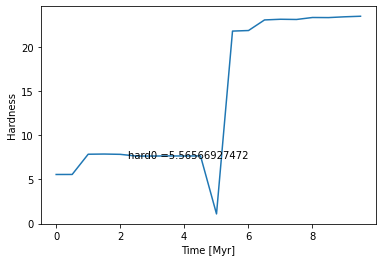

1


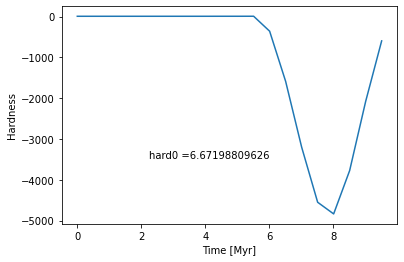

2


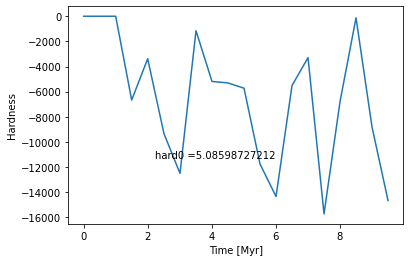

3


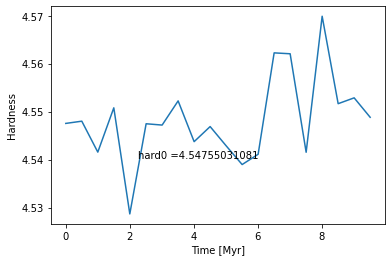

4


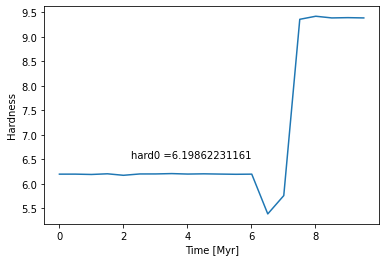

5


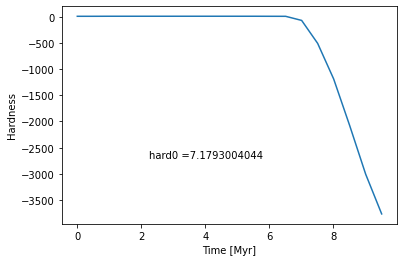

6


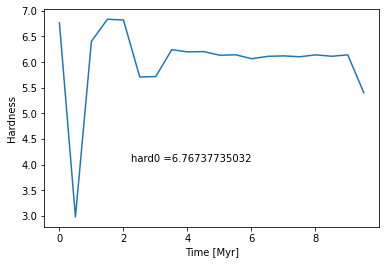

7


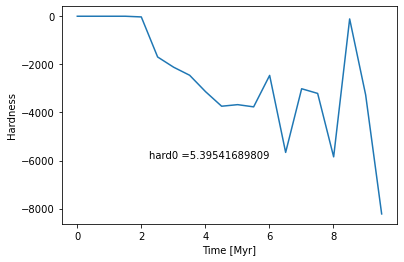

8


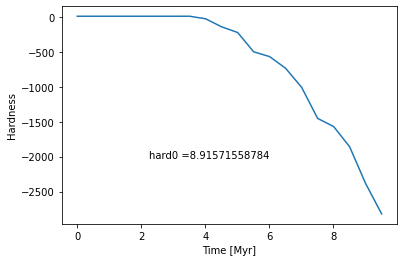

9


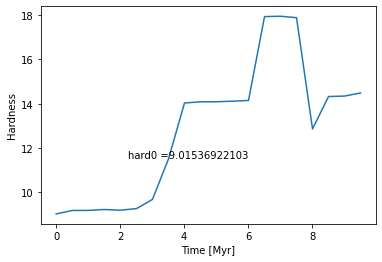

10


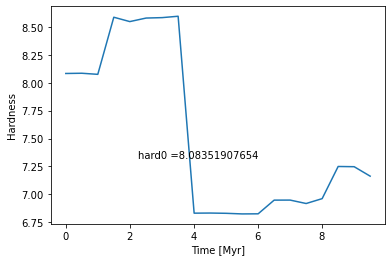

11


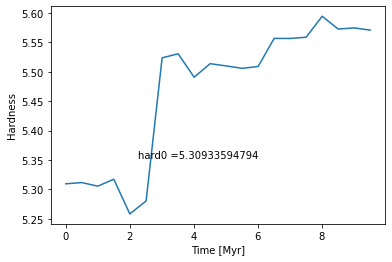

12


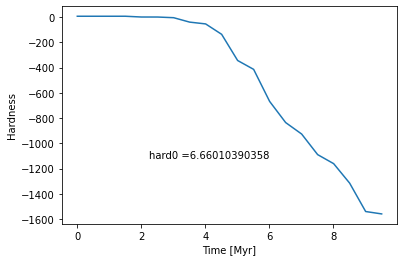

13


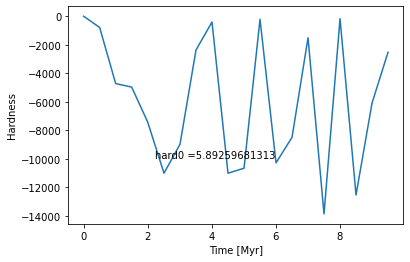

14


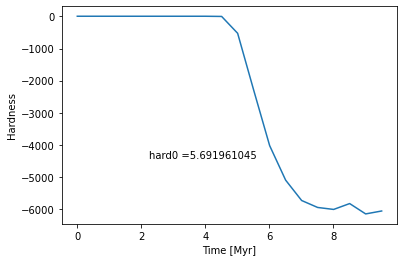

15


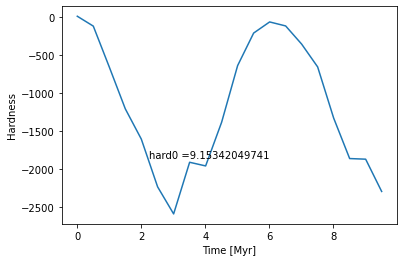

16


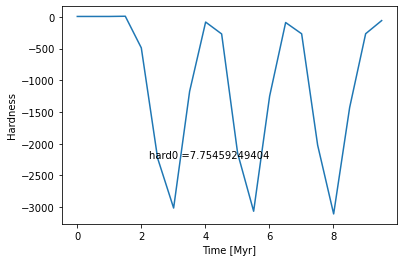

17


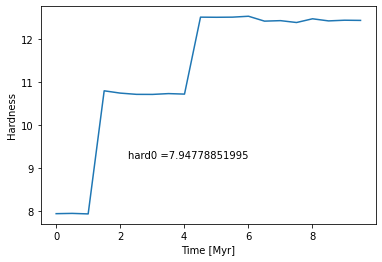

18


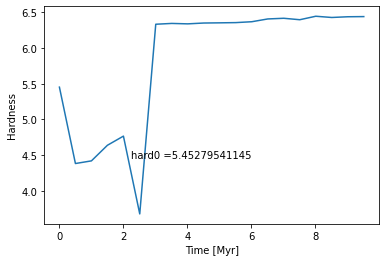

19


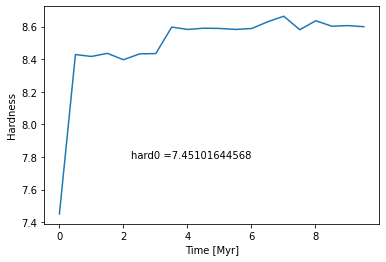

In [13]:
for i in range(N_BBH):
    print(i)
    plt.figure()
    plt.plot(BBH_info[:,i,0].astype('float'), BBH_info[:,i,5].astype('float'))
    plt.annotate(f'hard0 ='+str(BBH_info[:,i,5].astype('float')[0]), xy=(0.26,0.3), xycoords='axes fraction')
    plt.xlabel('Time [Myr]')
    plt.ylabel('Hardness')
    plt.show()

In [14]:
print(BBH[39*2:39*2+2].position)
print(BBH[40*2:40*2+2].position)

[] parsec
[] parsec


## Reference Simulation

In [68]:
SMBH_ref = SMBH0.copy()
BBH_ref = BBH0.copy()
bodies_ref = Particles(0)
bodies_ref.add_particles(SMBH_ref)
bodies_ref.add_particles(BBH_ref)

BBH_ref = bodies_ref[1:]
SMBH_ref = bodies_ref[0]

In [69]:
gravity = ph4(converter1, number_of_workers=32)
gravity.particles.add_particles(bodies_ref)
channel = gravity.particles.new_channel_to(bodies_ref)

fig_root = "figure/Ref/"

In [70]:
# Stopping condition of collision 
stopping_condition = gravity.stopping_conditions.collision_detection
stopping_condition.enable()
collision_radius_multiplication_factor = 1e5

bodies.radius *= collision_radius_multiplication_factor

# Evolving parameters
end_time = 10 | units.Myr
model_time = 0 | units.Myr
time = [] | units.Myr
dt = 1e-2 | units.Myr
x = 0

evolve_time_list = [] | units.Myr 

BBH_ref_info = []
aE_ref_info = []
SMBH_ref_info = []
# Evolve
while(model_time<end_time):
    
    ProgressBar(end_time.value_in(units.Myr), model_time.value_in(units.Myr))
    
    gravity.evolve_model(model_time)
    resolve_collision(stopping_condition, gravity, bodies) # Collisions detection
    channel.copy()
    
    
    if model_time.value_in(units.Myr)>=x:
        x += 0.5



        evolve_time_list.append(model_time)
        
        BBH_ref_info_time = []
        for i in range(N_BBH):
            name1, name2 = BBH_ref[i*2:i*2+2].name
            mass1, mass2 = BBH_ref[i*2:i*2+2].mass.value_in(units.MSun)
            a = BBH_ref[i*2].position - BBH_ref[i*+2+1].position
            hardness = get_hardness(BBH_ref[i*2:i*2+2], bodies)
            a = relative(BBH_ref[i*2].position, BBH_ref[i*2+1].position).value_in(units.au)
            r = relative(BBH_ref[i*2:i*2+2].center_of_mass(), SMBH_ref.position).value_in(units.pc)
            v1_v2 = relative(BBH_ref[i*2].velocity, BBH_ref[i*2+1].velocity).value_in(units.km/units.s)
            
            BBH_ref_info_time.append([model_time.value_in(units.Myr), 
                                  name1, name2, mass1, mass2, hardness, a, r, v1_v2])
        
        BBH_ref_info.append(BBH_ref_info_time)
        
        total_Ek=(0.5*bodies_ref.mass*(bodies_ref.vx**2+bodies_ref.vy**2+bodies_ref.vz**2)).sum()
        average_Ek=total_Ek/bodies_ref.mass.sum()
        aE_ref_info.append([model_time.value_in(units.Myr), average_Ek.value_in(units.km**2*units.s**(-2))])
        SMBH_ref_info.append([model_time.value_in(units.Myr), (sum(SMBH_ref.velocity.value_in(units.kms)**2))**(0.5)])
    model_time += dt
    

gravity.stop()

# plt.figure()
# plt.plot(evolve_time_list.value_in(units.Myr), average_Ek_list.value_in(units.kms**2))
# plt.xlabel('Evolve time [Myr]')
# plt.ylabel('Average Ek [(km/s)$^2$]')
# plt.savefig(fig_root+'average_Ek.png')
# plt.show()

[####################] 100% 

In [71]:
BBH_ref_info = np.array(BBH_ref_info)
aE_ref_info = np.array(aE_ref_info)
SMBH_ref_info = np.array(SMBH_ref_info)

0


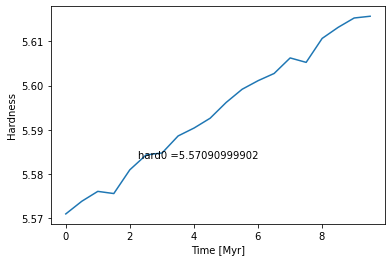

1


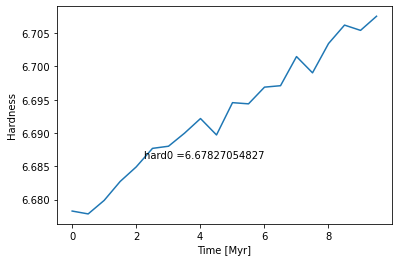

2


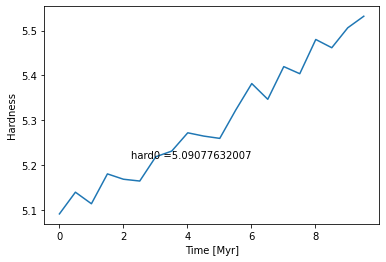

3


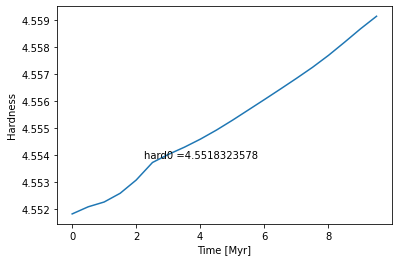

4


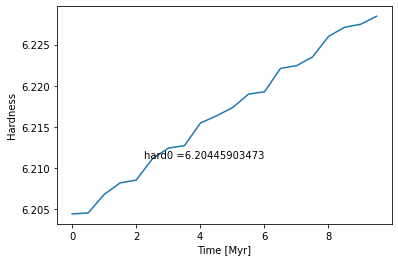

5


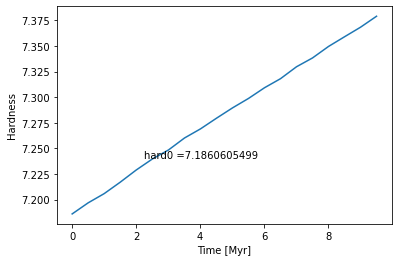

6


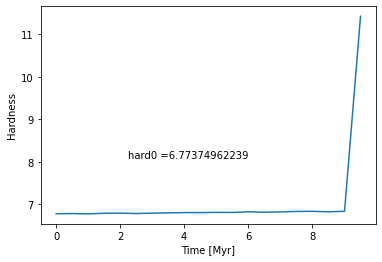

7


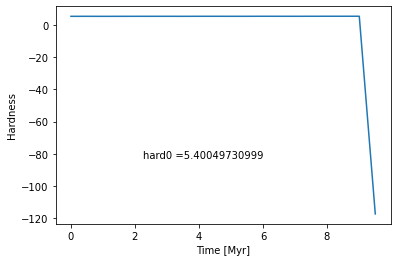

8


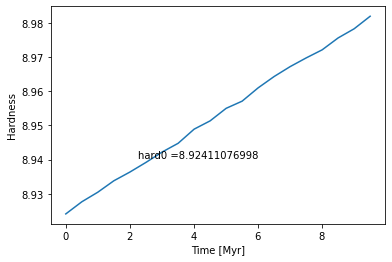

9


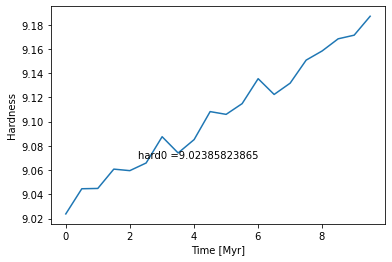

10


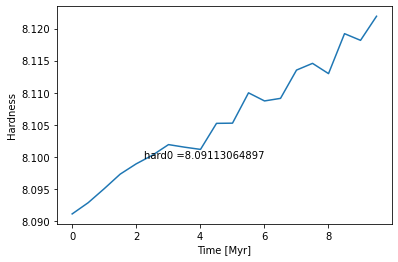

11


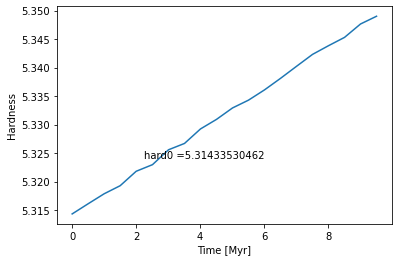

12


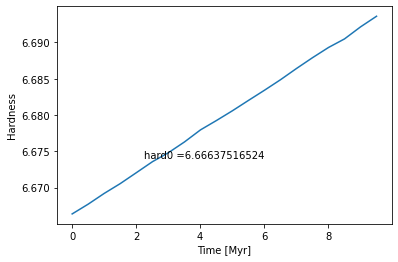

13


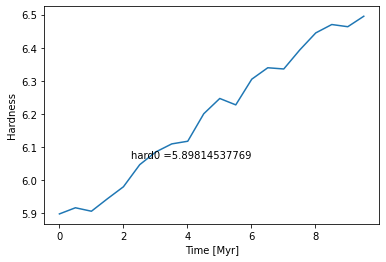

14


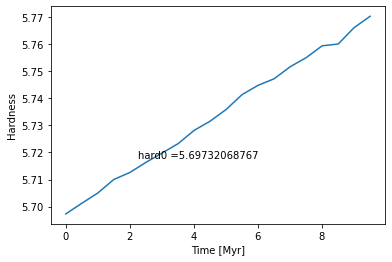

15


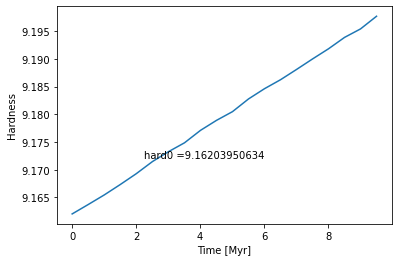

16


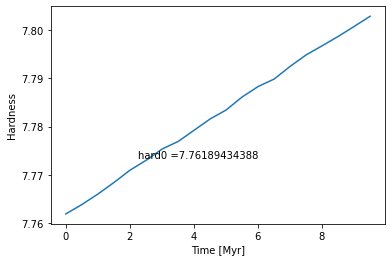

17


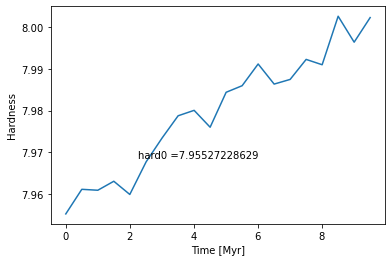

18


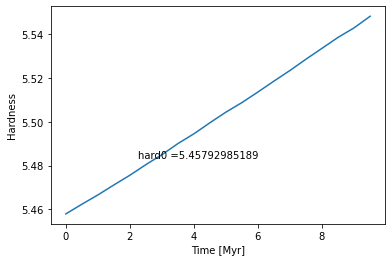

19


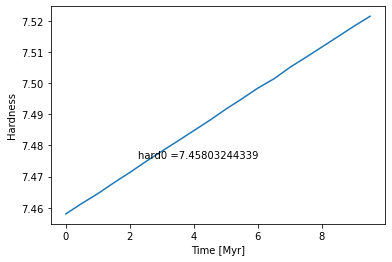

In [72]:
for i in range(N_BBH):
    print(i)
    plt.figure()
    plt.plot(BBH_ref_info[:,i,0].astype('float'), BBH_ref_info[:,i,5].astype('float'))
    plt.annotate(f'hard0 ='+str(BBH_ref_info[:,i,5].astype('float')[0]), xy=(0.26,0.3), xycoords='axes fraction')
    plt.xlabel('Time [Myr]')
    plt.ylabel('Hardness')
    plt.show()

0


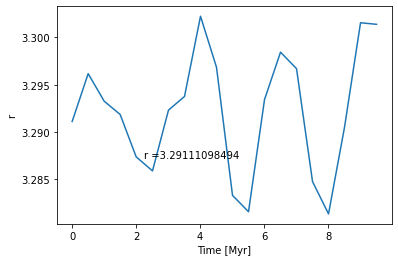

1


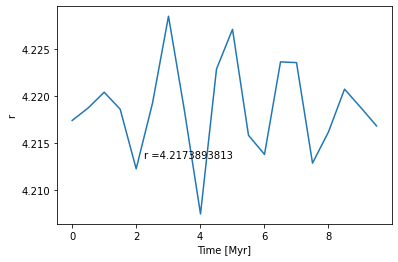

2


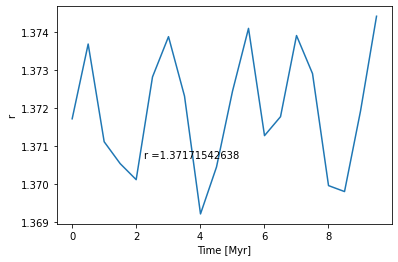

3


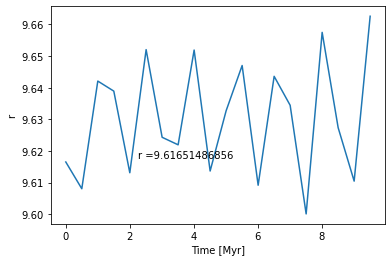

4


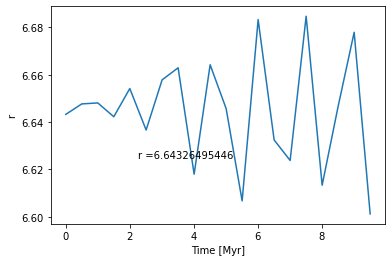

5


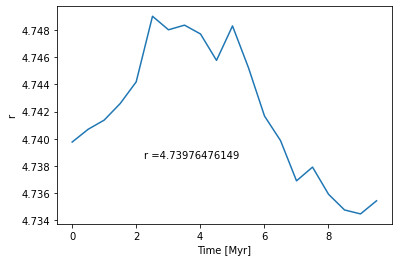

6


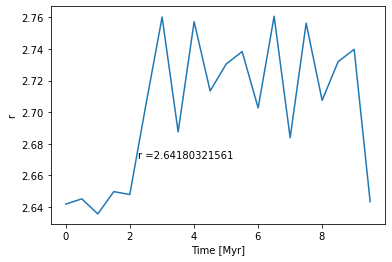

7


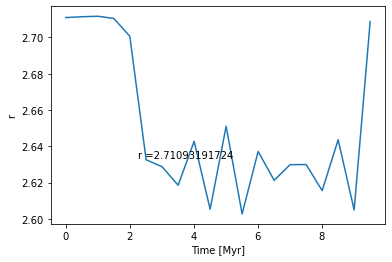

8


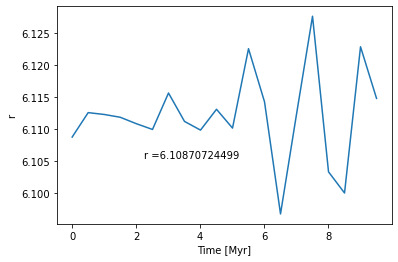

9


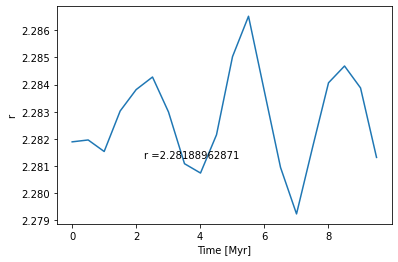

10


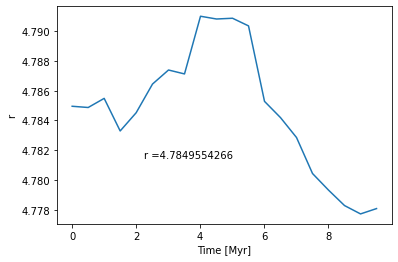

11


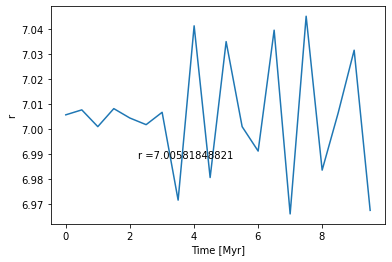

12


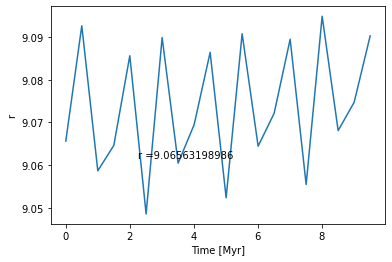

13


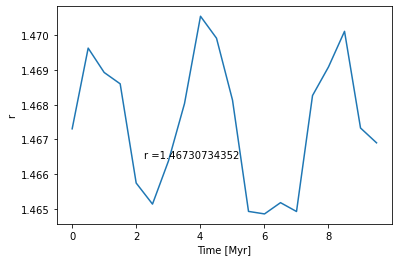

14


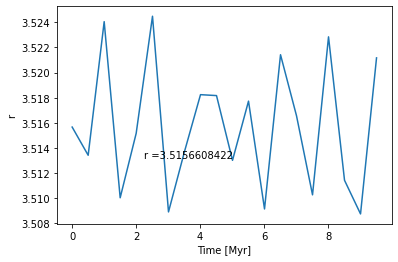

15


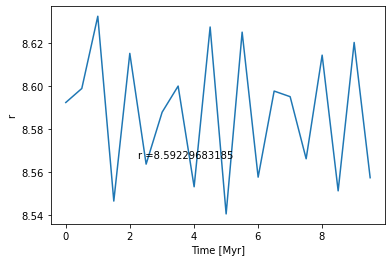

16


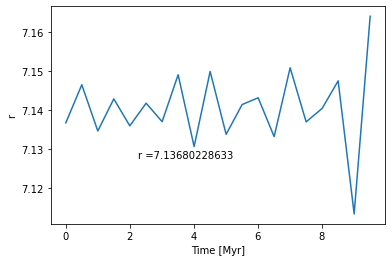

17


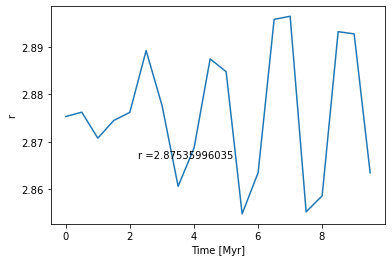

18


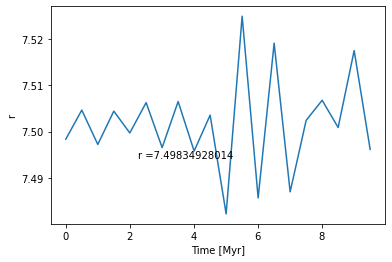

19


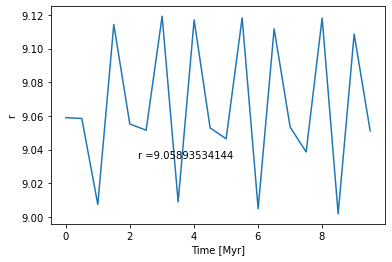

In [75]:
for i in range(N_BBH):
    print(i)
    plt.figure()
    plt.plot(BBH_ref_info[:,i,0].astype('float'), BBH_ref_info[:,i,7].astype('float'))
    plt.annotate(f'r ='+str(BBH_ref_info[:,i,7].astype('float')[0]), xy=(0.26,0.3), xycoords='axes fraction')
    plt.xlabel('Time [Myr]')
    plt.ylabel('r')
    plt.show()

In [61]:
print(aE_ref_info[:,1])

[ 0.21613744  0.21576251  0.21609868  0.21591494  0.21611183  0.21598954
  0.21530586  0.21675922  0.21548917  0.2160481   0.21544446  0.21623949
  0.21647049  0.21529904  0.21626691  0.21588617  0.21659211  0.21562396
  0.21566762  0.21615712]


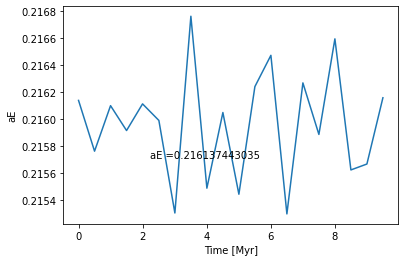

In [73]:
plt.figure()
plt.plot(aE_ref_info[:,0].astype('float'), aE_ref_info[:,1])
plt.annotate(f'aE ='+str(aE_ref_info[0,1]), xy=(0.26,0.3), xycoords='axes fraction')
plt.xlabel('Time [Myr]')
plt.ylabel('aE')
plt.show()

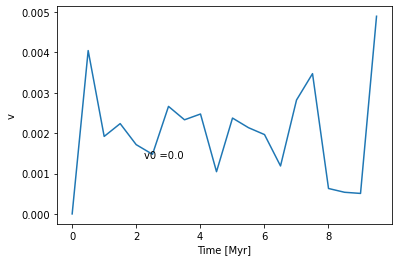

In [74]:
plt.figure()
plt.plot(SMBH_ref_info[:,0].astype('float'), SMBH_ref_info[:,1])
plt.annotate(f'v0 ='+str(SMBH_ref_info[0,1]), xy=(0.26,0.3), xycoords='axes fraction')
plt.xlabel('Time [Myr]')
plt.ylabel('v')
plt.show()

## Bridge Nbody and Hydro

In [7]:
bodies = Particles(0)
bodies.add_particles(SMBH0)
bodies.add_particles(BHdisk0)

SMBH = bodies[bodies.name=="SMBH"]
BHdisk = bodies[bodies.name!="SMBH"]

Nbody = SMBH+BHdisk

gravityA = ph4(converter2, number_of_workers=32)
gravityA.particles.add_particles(Nbody)
channel = {"from_BHs": bodies.new_channel_to(gravityA.particles),
            "to_BHs": gravityA.particles.new_channel_to(bodies)}

hydro = Fi(converter2, mode="openmp", workers=32)
hydro.parameters.use_hydro_flag = True
hydro.parameters.radiation_flag = False
hydro.parameters.gamma = 1
hydro.parameters.isothermal_flag = True
hydro.parameters.integrate_entropy_flag = False
hydro.parameters.timestep = 5e2 | units.yr
hydro.parameters.verbosity = 0
hydro.parameters.eps_is_h_flag = False    # h_smooth is constant
eps = 10 | units.au
hydro.parameters.gas_epsilon = eps
hydro.parameters.sph_h_const = eps

bodies.add_particles(gasdisk0)
gasdisk = bodies[bodies.name=="gas disk"]

hydro.particles.add_particles(gasdisk)
# hydro.dm_particles.add_particles(SMBH.as_set())
channel.update({"from_gasdisk": gasdisk.new_channel_to(hydro.particles)})
channel.update({"to_gasdisk": hydro.particles.new_channel_to(gasdisk)})
# channel.update({"from_smbh": SMBH.new_channel_to(hydro.dm_particles)})
# channel.update({"to_smbh": hydro.dm_particles.new_channel_to(SMBH)})

fig_root = "figure/Bridge/"

In [8]:
# Bridge gravity and hydro
gravhydro = bridge.Bridge(use_threading=False) #, method=SPLIT_4TH_S_M4)
gravhydro.add_system(gravityA, (hydro,))
gravhydro.add_system(hydro, (gravityA,))

# Stopping condition of collision 
stopping_condition = gravityA.stopping_conditions.collision_detection
stopping_condition.enable()
collision_radius_multiplication_factor = 1e5

Nbody.radius *= collision_radius_multiplication_factor

# Bridge timestep
gravhydro.timestep = 5e3 | units.yr

Evolved to t = 0 Myr 
BH number = 300
3 Binary found
Binary 1 is ['BH262' 'BH114'] with hardness = 0.665417273026 d = 12025.6583376 au v = 2.92863159078 kms radius = 1.27139428049 parsec and theta_z = 0.158262870215
Binary 2 is ['BH86' 'BH181'] with hardness = 1.00556662181 d = 12322.9016172 au v = 0.405092307386 kms radius = 6.61316586558 parsec and theta_z = 0.93974096012
Binary 3 is ['BH291' 'BH168'] with hardness = 1.28966580655 d = 10130.1502286 au v = 0.302430732821 kms radius = 6.30301605081 parsec and theta_z = 0.682336803772


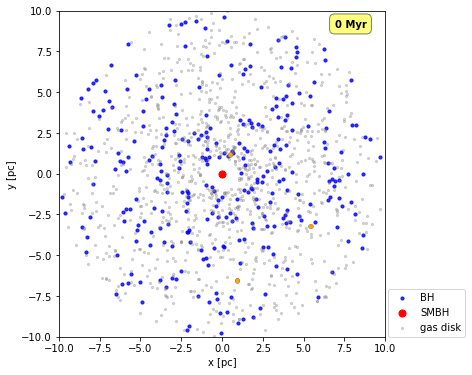



Evolved to t = 1 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH168'] with hardness = 1.62969299239 d = 6340.77418409 au v = 3.20974383095 kms radius = 6.65706689682 parsec and theta_z = -0.0512201086031


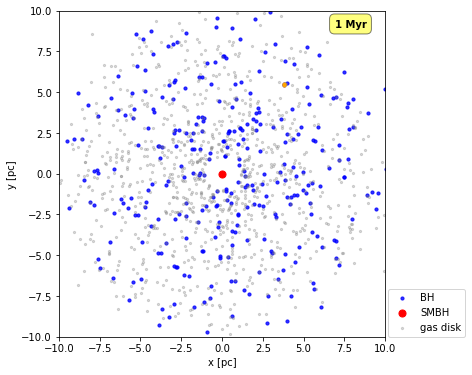



Evolved to t = 2 Myr 
BH number = 300
2 Binary found
Binary 1 is ['BH168' 'BH291'] with hardness = 1.6267976883 d = 5878.42061599 au v = 3.77758911002 kms radius = 6.12747049188 parsec and theta_z = -0.0508231484806
Binary 2 is ['BH264' 'BH266'] with hardness = 0.516127439869 d = 4651.24165664 au v = 6.29053527831 kms radius = 2.96349230652 parsec and theta_z = -0.346346846529


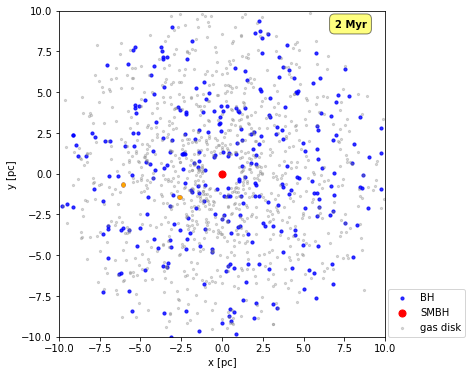



Evolved to t = 3 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH168' 'BH291'] with hardness = 1.69527727533 d = 5633.93806998 au v = 3.87794566913 kms radius = 6.40996399273 parsec and theta_z = -0.0626998422854


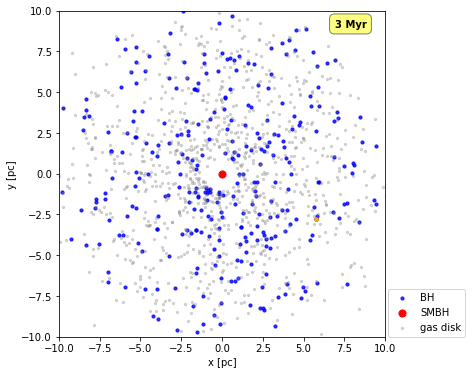



Evolved to t = 4 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH168' 'BH291'] with hardness = 1.6722887851 d = 7353.88250859 au v = 1.65693244022 kms radius = 6.51572529066 parsec and theta_z = -0.323641123005


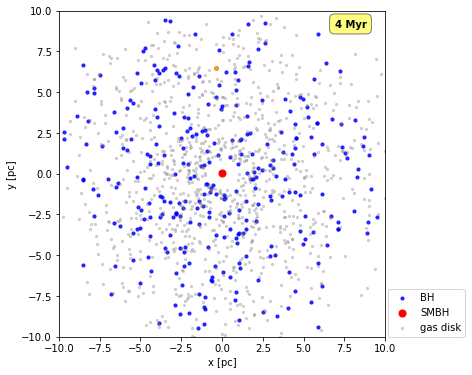



Evolved to t = 5 Myr 
BH number = 300
2 Binary found
Binary 1 is ['BH168' 'BH291'] with hardness = 1.68207724969 d = 7621.69778372 au v = 0.996454080729 kms radius = 6.14668604638 parsec and theta_z = -0.211073023648
Binary 2 is ['BH149' 'BH244'] with hardness = 0.536498021457 d = 17098.2507902 au v = 2.0226921364 kms radius = 6.38233741897 parsec and theta_z = -0.0233253969079


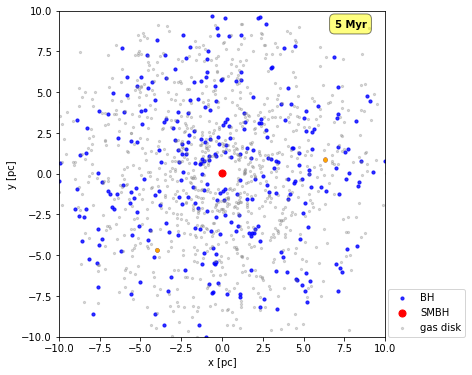



Evolved to t = 6 Myr 
BH number = 300
2 Binary found
Binary 1 is ['BH149' 'BH244'] with hardness = 0.583605056843 d = 11592.3509708 au v = 3.30690219221 kms radius = 6.68514746188 parsec and theta_z = -0.38463219822
Binary 2 is ['BH168' 'BH291'] with hardness = 1.6944873354 d = 6803.82822292 au v = 2.35354887601 kms radius = 5.53077196053 parsec and theta_z = 0.0200329798152


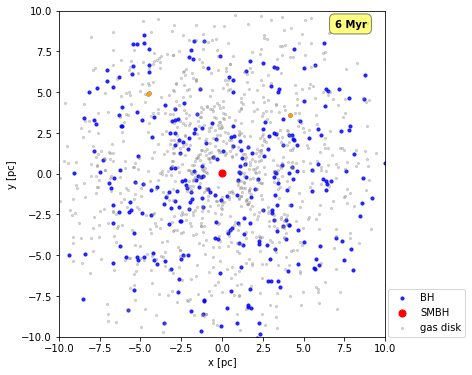



Evolved to t = 7 Myr 
BH number = 300
3 Binary found
Binary 1 is ['BH149' 'BH244'] with hardness = 0.656870684782 d = 15795.452607 au v = 1.58155786375 kms radius = 6.32989603187 parsec and theta_z = -0.270133235895
Binary 2 is ['BH200' 'BH242'] with hardness = 0.52603439685 d = 11371.1890378 au v = 3.01982054983 kms radius = 4.94168411855 parsec and theta_z = -0.0531341074022
Binary 3 is ['BH206' 'BH291'] with hardness = 2.07721811506 d = 3935.62595666 au v = 5.16125321604 kms radius = 5.56344907583 parsec and theta_z = 0.853363157906


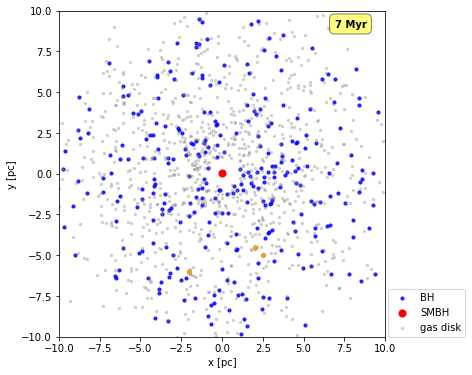



Evolved to t = 8 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH206'] with hardness = 2.13760172089 d = 2552.50185489 au v = 8.21514438882 kms radius = 5.1055501887 parsec and theta_z = 0.853773878868


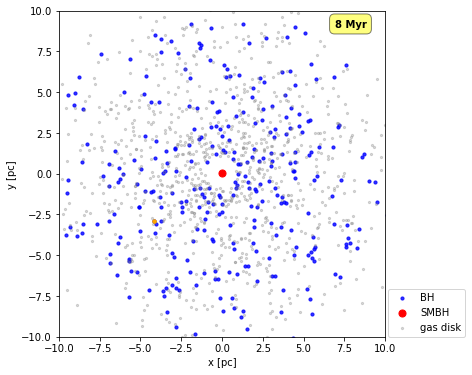



Evolved to t = 9 Myr 
BH number = 300
2 Binary found
Binary 1 is ['BH206' 'BH291'] with hardness = 2.29905500563 d = 3906.29989536 au v = 4.64778548015 kms radius = 5.01462489721 parsec and theta_z = 0.817440927895
Binary 2 is ['BH242' 'BH200'] with hardness = 0.574326067471 d = 17615.7924614 au v = 0.444826565321 kms radius = 6.03975611904 parsec and theta_z = 0.374661001541


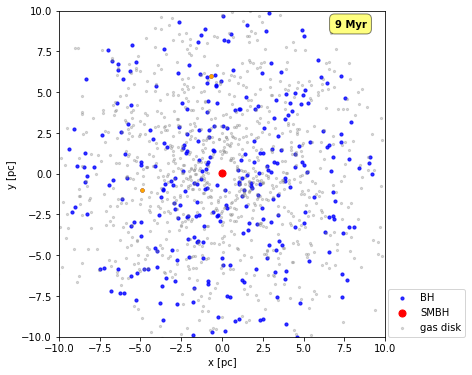



Evolved to t = 10 Myr 
BH number = 300
2 Binary found
Binary 1 is ['BH206' 'BH291'] with hardness = 2.35150161519 d = 3416.70606279 au v = 5.70227259683 kms radius = 4.82923652382 parsec and theta_z = 0.765363376065
Binary 2 is ['BH200' 'BH242'] with hardness = 0.604839733655 d = 8362.09161396 au v = 3.90640420937 kms radius = 5.29335708449 parsec and theta_z = 0.183329203017


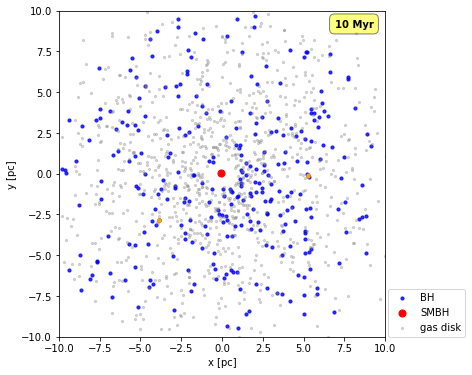



Evolved to t = 11 Myr 
BH number = 300
2 Binary found
Binary 1 is ['BH206' 'BH291'] with hardness = 2.32824535556 d = 3371.04211556 au v = 5.80678747456 kms radius = 4.99141851 parsec and theta_z = 0.727292145144
Binary 2 is ['BH200' 'BH242'] with hardness = 0.595441274171 d = 6521.23437101 au v = 4.86541550078 kms radius = 5.13577508451 parsec and theta_z = 0.049597939144


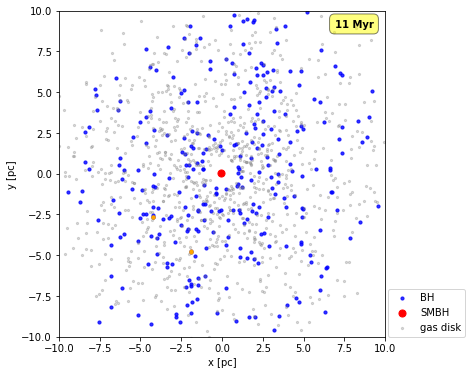



Evolved to t = 12 Myr 
BH number = 300
2 Binary found
Binary 1 is ['BH206' 'BH291'] with hardness = 2.36449331699 d = 2614.54516775 au v = 7.68084800523 kms radius = 5.44917625609 parsec and theta_z = 0.709462466668
Binary 2 is ['BH242' 'BH200'] with hardness = 0.562941949981 d = 16994.480872 au v = 1.10400446114 kms radius = 6.14225879739 parsec and theta_z = 0.368066167715


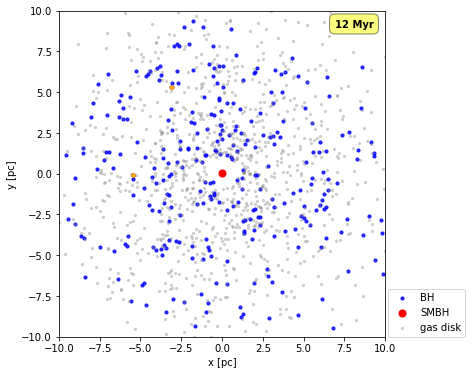



Evolved to t = 13 Myr 
BH number = 300
4 Binary found
Binary 1 is ['BH206' 'BH291'] with hardness = 2.32981307741 d = 3327.08140237 au v = 5.86945102422 kms radius = 5.37702147186 parsec and theta_z = 0.686840685003
Binary 2 is ['BH161' 'BH112'] with hardness = 0.634117407302 d = 21380.4467846 au v = 0.806111203711 kms radius = 2.23413874955 parsec and theta_z = -0.570424639903
Binary 3 is ['BH100' 'BH262'] with hardness = 1.16465928644 d = 3835.21938377 au v = 5.69602446817 kms radius = 1.15058414675 parsec and theta_z = 0.337304475747
Binary 4 is ['BH242' 'BH200'] with hardness = 0.63827035247 d = 3224.28422948 au v = 7.82457848119 kms radius = 5.2741532022 parsec and theta_z = 0.158823545745


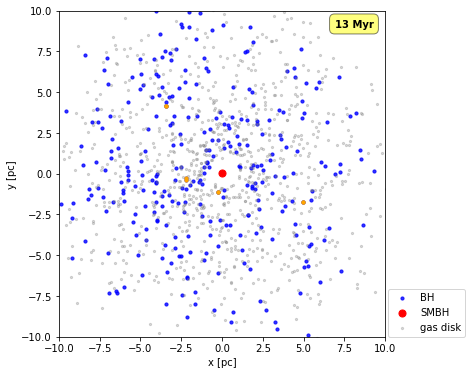



Evolved to t = 14 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH206' 'BH291'] with hardness = 2.38747581495 d = 3119.86961466 au v = 6.32122680353 kms radius = 5.58717276351 parsec and theta_z = 0.69044527857


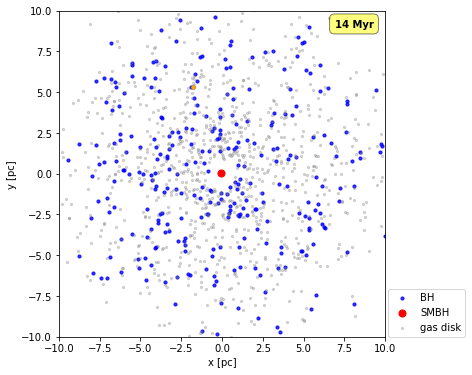



Evolved to t = 15 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH206'] with hardness = 2.35622489963 d = 2167.96575065 au v = 9.0552093927 kms radius = 5.18377142468 parsec and theta_z = 0.711112420452


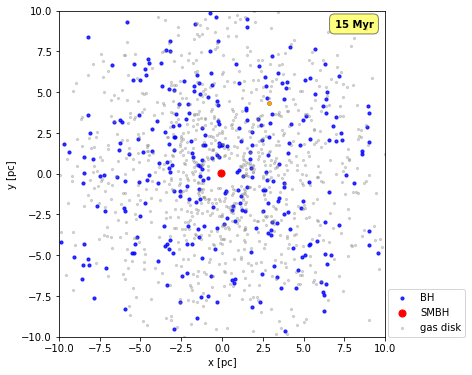



Evolved to t = 16 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH206' 'BH291'] with hardness = 2.56424721637 d = 3788.45980597 au v = 4.28954632829 kms radius = 4.90318601655 parsec and theta_z = 0.721414454663


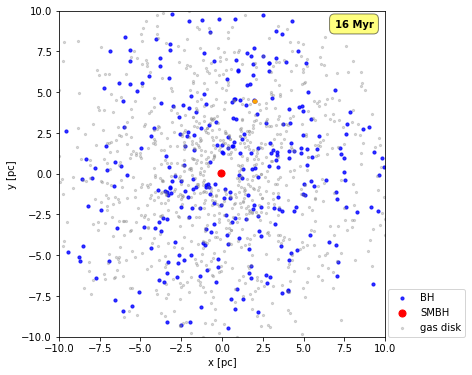



Evolved to t = 17 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH206' 'BH291'] with hardness = 2.59050691106 d = 3421.973138 au v = 5.16085441944 kms radius = 5.00274827253 parsec and theta_z = 0.765789809622


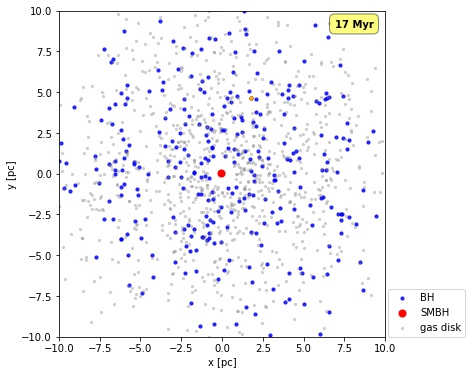



Evolved to t = 18 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH206'] with hardness = 2.54135536299 d = 1057.99103406 au v = 14.9239361359 kms radius = 5.0748357477 parsec and theta_z = 0.790305391357


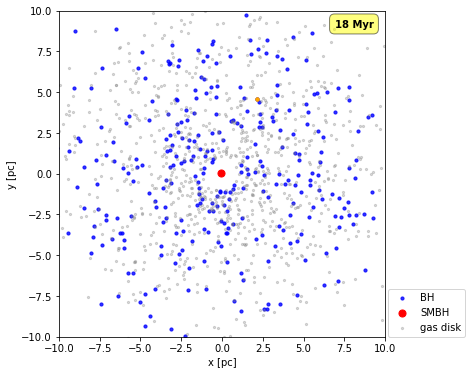



Evolved to t = 19 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 3.37446016892 d = 1276.85380712 au v = 12.2397144909 kms radius = 4.97383894898 parsec and theta_z = 0.427593379696


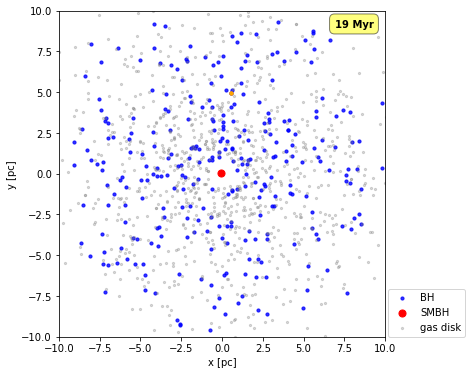



Evolved to t = 20 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 3.25819718158 d = 1120.48469955 au v = 13.4782923103 kms radius = 4.98884907828 parsec and theta_z = 0.452955619723


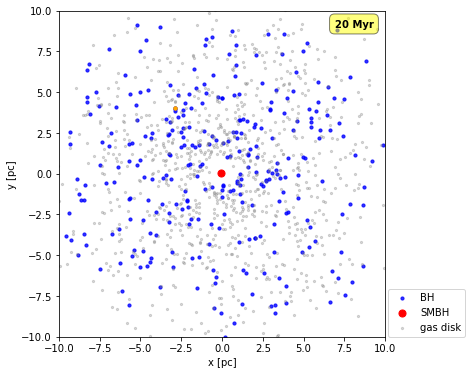



Evolved to t = 21 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 3.29016102816 d = 2380.11307711 au v = 6.59726927049 kms radius = 4.78684077374 parsec and theta_z = 0.487854875107


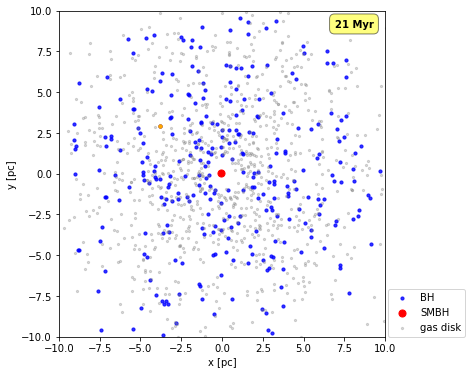



Evolved to t = 22 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 3.3391978796 d = 2791.99815934 au v = 5.0344612625 kms radius = 4.60061193209 parsec and theta_z = 0.531039934202


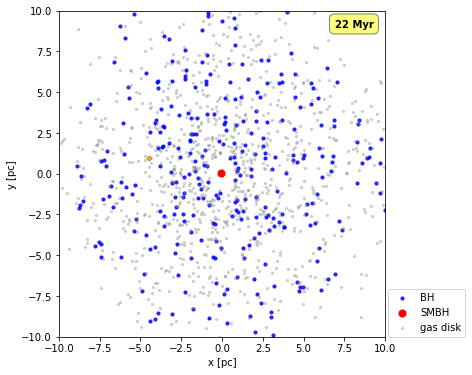



Evolved to t = 23 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 3.42831544192 d = 2652.86320648 au v = 5.49517868433 kms radius = 4.56070710795 parsec and theta_z = 0.600596345412


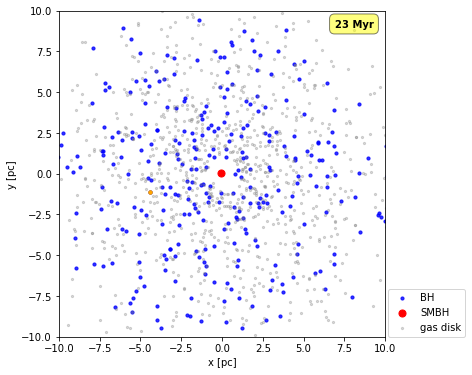



Evolved to t = 24 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 3.35850526496 d = 1967.20174612 au v = 8.28343739004 kms radius = 4.58665082328 parsec and theta_z = 0.688597080259


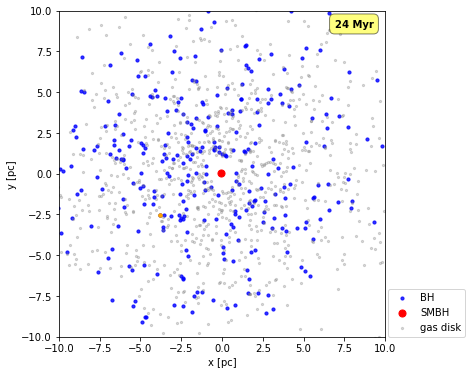



Evolved to t = 25 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 3.41143569279 d = 3059.38853269 au v = 3.93445809789 kms radius = 4.80487155633 parsec and theta_z = 0.747299887932


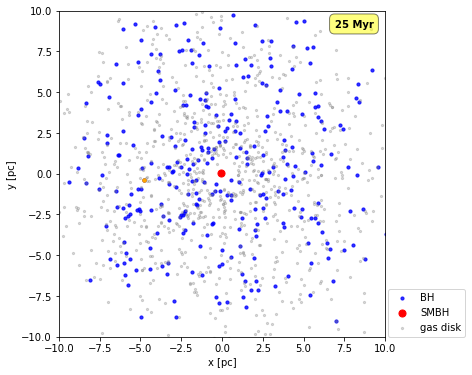



Evolved to t = 26 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 3.30856596836 d = 700.425352523 au v = 18.3742614085 kms radius = 4.65206596151 parsec and theta_z = 0.725234553975


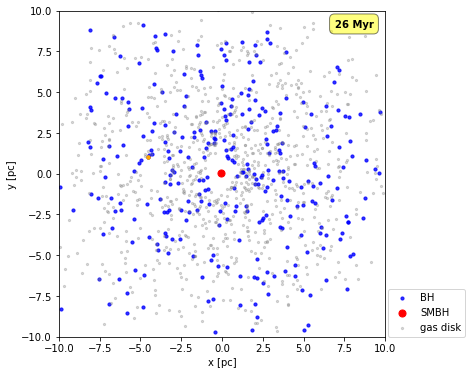



Evolved to t = 27 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 3.18574317987 d = 2230.58739318 au v = 7.46300203155 kms radius = 4.7017593192 parsec and theta_z = -0.0454140350631


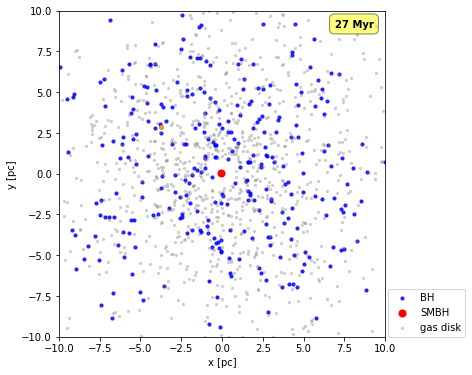



Evolved to t = 28 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 3.21707489315 d = 1939.52766432 au v = 8.68010719099 kms radius = 4.57487596209 parsec and theta_z = -0.0424728362695


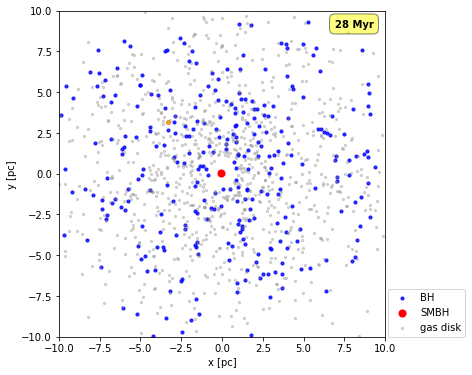



Evolved to t = 29 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 3.08248067791 d = 1888.07741531 au v = 8.91331443684 kms radius = 4.3967366673 parsec and theta_z = -0.0424529497102


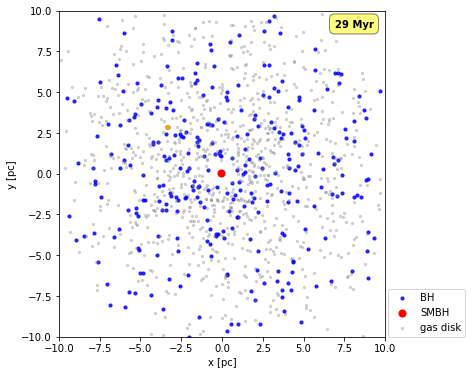



Evolved to t = 30 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 3.17466572154 d = 1238.00999976 au v = 12.6852560898 kms radius = 4.2698074288 parsec and theta_z = -0.0597087636688


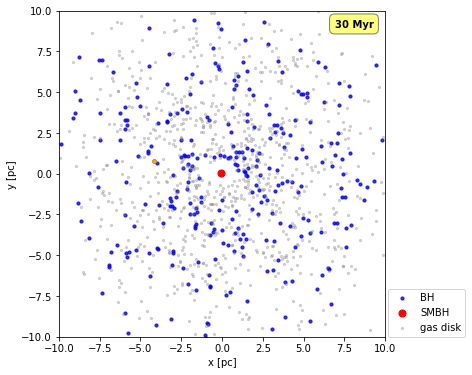



Evolved to t = 31 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 3.13574307339 d = 1610.39105572 au v = 10.3037535035 kms radius = 4.41601144171 parsec and theta_z = -0.0660018098518


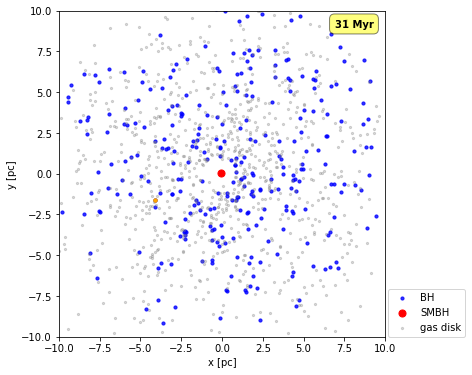



Evolved to t = 32 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 3.19606603019 d = 2209.29570174 au v = 7.53680909449 kms radius = 4.80170863474 parsec and theta_z = -0.0622695309929


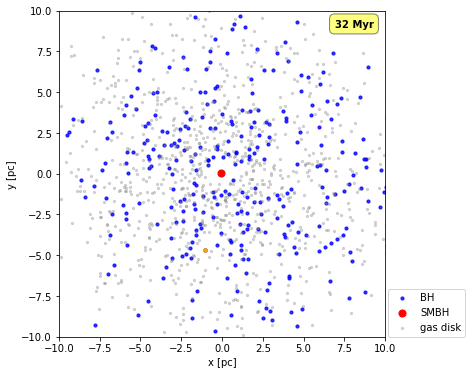



Evolved to t = 33 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 3.22062561924 d = 2438.89280936 au v = 6.65068049559 kms radius = 4.94041334829 parsec and theta_z = -0.112507522138


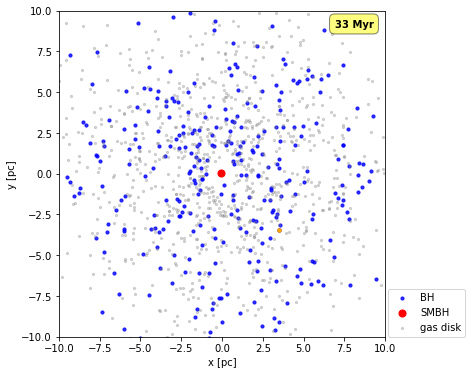



Evolved to t = 34 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 3.09107104677 d = 446.287809562 au v = 24.1035095911 kms radius = 4.920230389 parsec and theta_z = 0.0349234469775


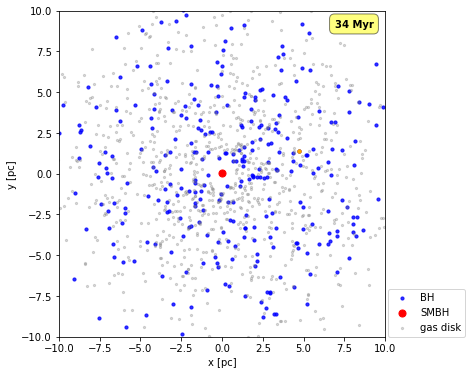



Evolved to t = 35 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 3.91569792668 d = 3162.55053306 au v = 1.03876360517 kms radius = 4.30493518422 parsec and theta_z = -0.140484073114


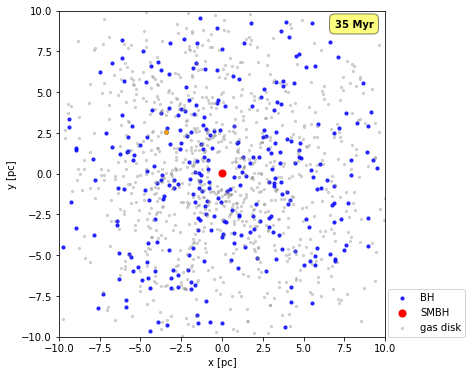



Evolved to t = 36 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 3.87607055777 d = 1141.8223264 au v = 12.8029730365 kms radius = 4.11924387822 parsec and theta_z = -0.060322826377


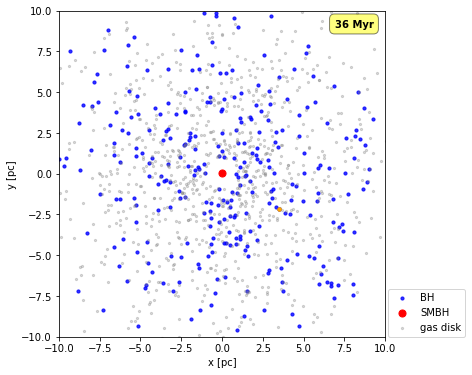



Evolved to t = 37 Myr 
BH number = 300
2 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 3.89797473448 d = 2868.92829683 au v = 3.0984337132 kms radius = 4.2076302402 parsec and theta_z = -0.0391712852739
Binary 2 is ['BH224' 'BH232'] with hardness = 0.826151292967 d = 15731.6995715 au v = 1.5973072997 kms radius = 3.74228461205 parsec and theta_z = 0.336990801604


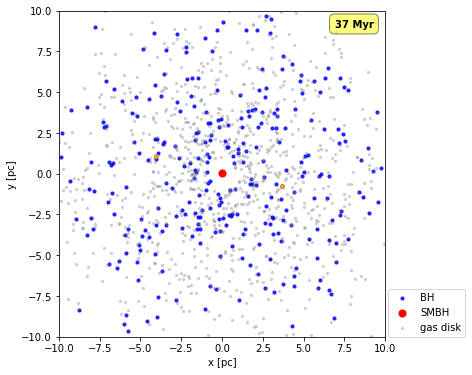



Evolved to t = 38 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 3.90108671569 d = 2517.06835712 au v = 4.87247351246 kms radius = 4.15803316676 parsec and theta_z = -0.0290301164496


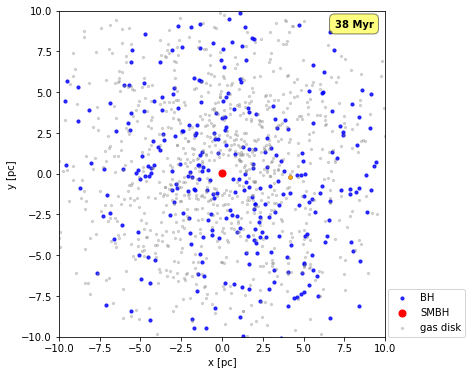



Evolved to t = 39 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 3.9105983713 d = 1234.78562549 au v = 11.9857494561 kms radius = 3.95784994188 parsec and theta_z = -0.0368373119393


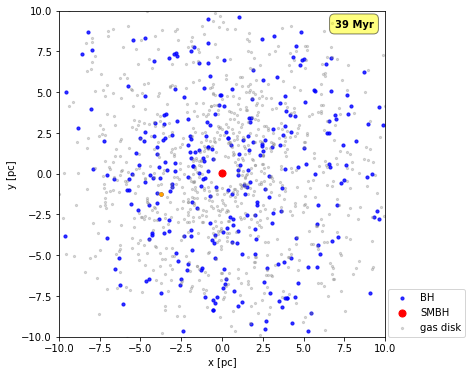



Evolved to t = 40 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 3.88815555997 d = 2836.66176302 au v = 3.15483498576 kms radius = 3.98873723991 parsec and theta_z = -0.0280044897434


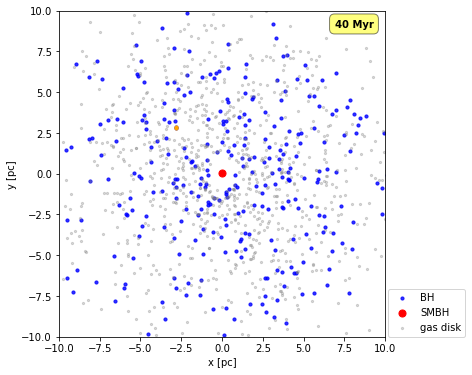



Evolved to t = 41 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 3.89545321604 d = 2057.92303137 au v = 6.98410307303 kms radius = 4.04889124862 parsec and theta_z = -0.00564775845506


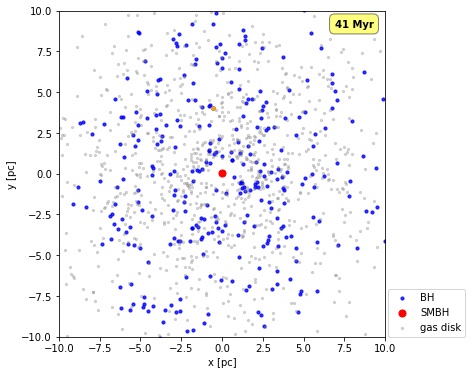



Evolved to t = 42 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.47473025422 d = 2329.78000188 au v = 4.24254773881 kms radius = 4.16314660473 parsec and theta_z = 0.143922451918


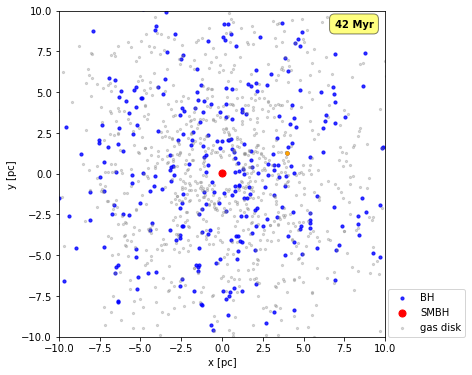



Evolved to t = 43 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.63402379455 d = 2438.50843651 au v = 3.21161896031 kms radius = 4.00458912234 parsec and theta_z = 0.0456218516286


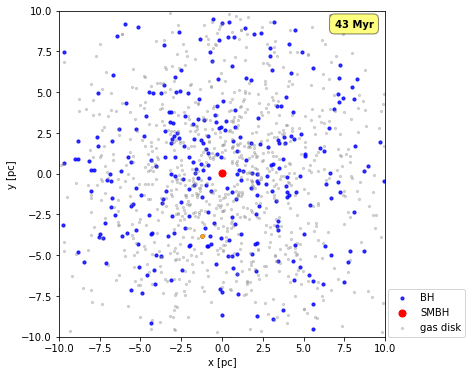



Evolved to t = 44 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.6080598291 d = 2226.71797052 au v = 4.63444820962 kms radius = 4.37820571542 parsec and theta_z = 0.0573780357508


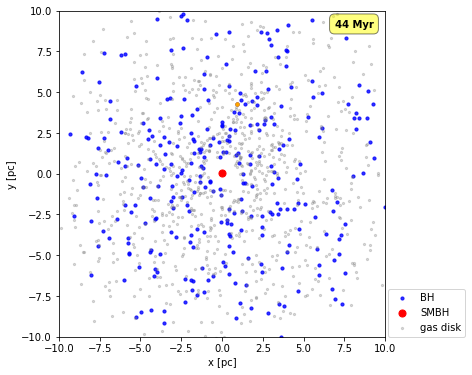



Evolved to t = 45 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.60609573194 d = 771.284630905 au v = 16.4075455515 kms radius = 4.31141076739 parsec and theta_z = 0.0557048502422


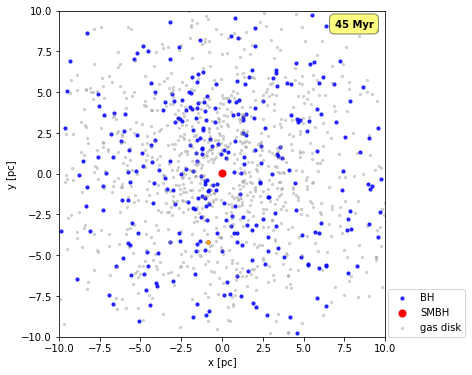



Evolved to t = 46 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.71766177285 d = 1993.07012362 au v = 6.06604477957 kms radius = 4.57573230304 parsec and theta_z = 0.0591631391707


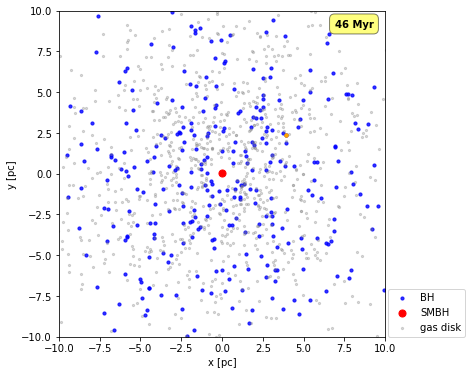



Evolved to t = 47 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.59906031384 d = 2039.30949792 au v = 5.77492728625 kms radius = 4.17543440188 parsec and theta_z = 0.0576015560549


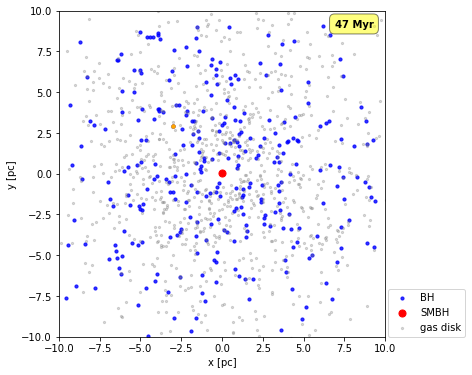



Evolved to t = 48 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.694024913 d = 2019.6857845 au v = 5.89721826982 kms radius = 4.56002148893 parsec and theta_z = 0.0585345896695


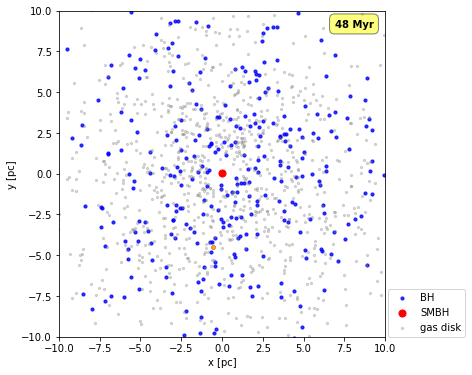



Evolved to t = 49 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.70578047416 d = 1988.76019876 au v = 6.07369054102 kms radius = 4.46455194532 parsec and theta_z = 0.0671638087065


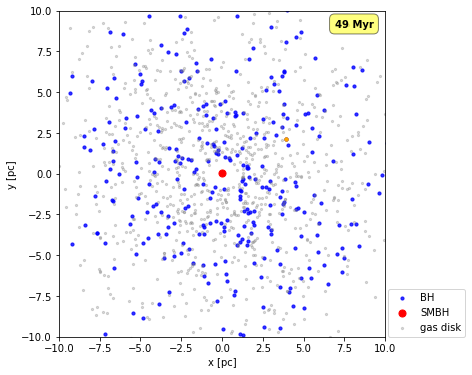



Evolved to t = 50 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 4.58255593939 d = 1873.04884272 au v = 6.7754659062 kms radius = 4.03036863912 parsec and theta_z = 0.0819629014069


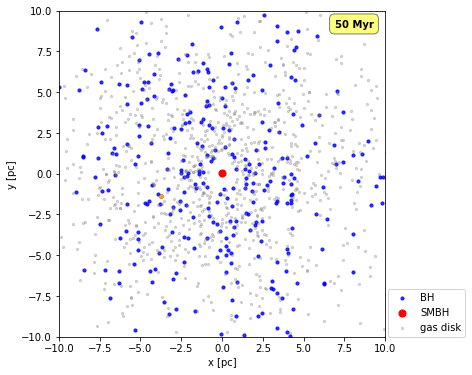



Evolved to t = 51 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 4.76054120993 d = 1753.44313376 au v = 7.51310056501 kms radius = 4.80207204518 parsec and theta_z = 0.107068749236


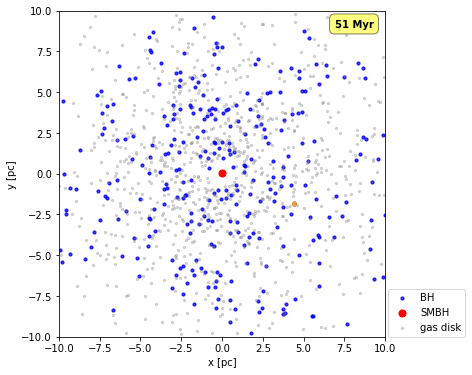



Evolved to t = 52 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 4.58392100915 d = 2369.88335676 au v = 3.59202521194 kms radius = 4.16497070007 parsec and theta_z = 0.16144338814


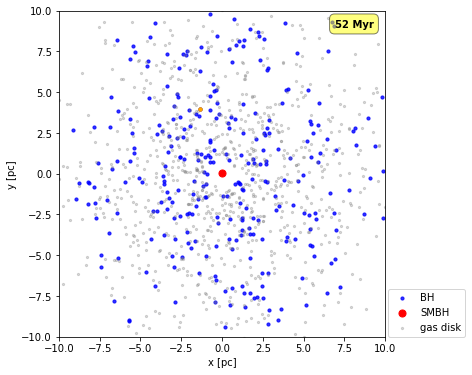



Evolved to t = 53 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.57991589521 d = 700.909433895 au v = 17.5415090026 kms radius = 4.4783049528 parsec and theta_z = 0.293179188444


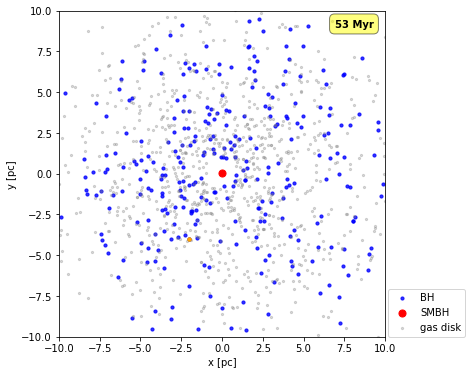



Evolved to t = 54 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 4.69535179456 d = 2470.44020995 au v = 2.83405405479 kms radius = 4.40333417668 parsec and theta_z = 0.666520952982


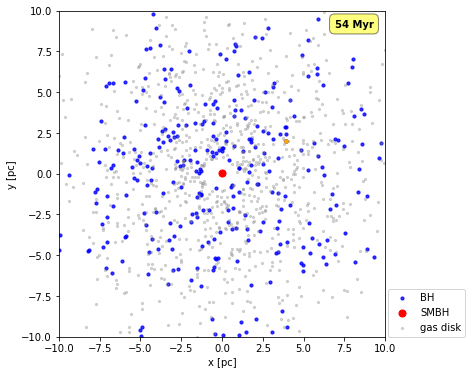



Evolved to t = 55 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 4.64528778035 d = 2539.4131069 au v = 1.95033106308 kms radius = 4.16903387759 parsec and theta_z = 0.559701294882


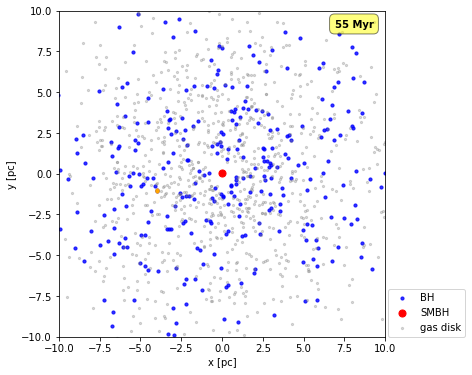



Evolved to t = 56 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.5742630219 d = 1172.03197036 au v = 11.7495438276 kms radius = 4.48112695793 parsec and theta_z = 0.390020467307


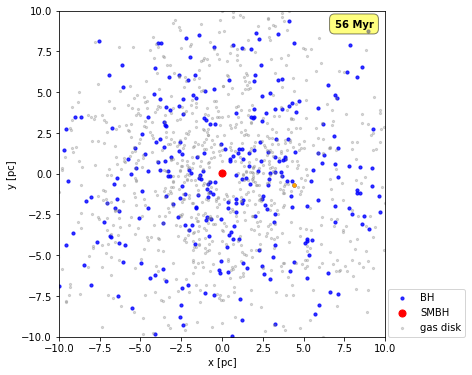



Evolved to t = 57 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 4.6594848408 d = 2099.56089635 au v = 5.16957977936 kms radius = 4.04373840498 parsec and theta_z = 0.324495214175


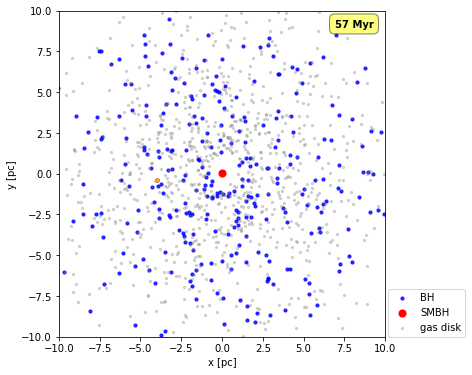



Evolved to t = 58 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 4.88916214668 d = 1460.80968054 au v = 9.3526784093 kms radius = 4.32941702761 parsec and theta_z = 0.290441587346


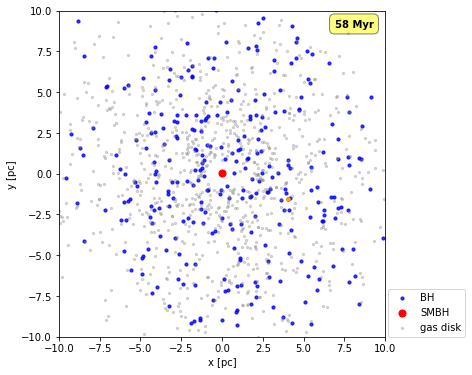



Evolved to t = 59 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 4.67610855273 d = 1271.19516007 au v = 10.8275942751 kms radius = 4.17821603233 parsec and theta_z = 0.272219299535


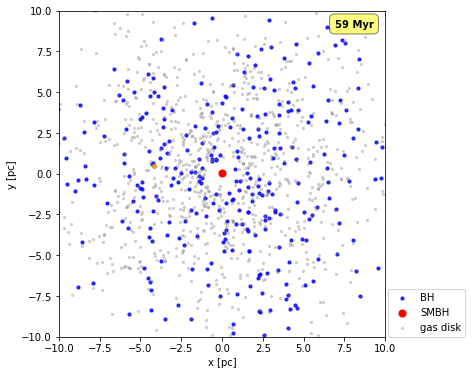



Evolved to t = 60 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 4.84010584705 d = 1781.11071082 au v = 7.16302526288 kms radius = 4.53805447066 parsec and theta_z = 0.26101693731


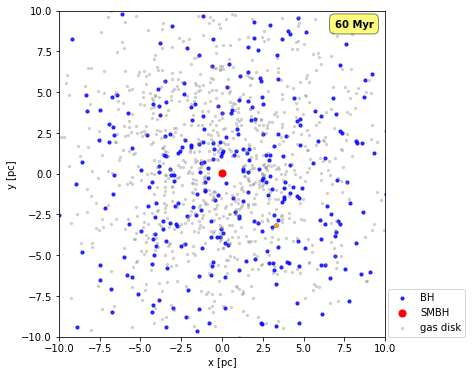



Evolved to t = 61 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.76163840596 d = 824.542058485 au v = 15.5577533635 kms radius = 4.90816039065 parsec and theta_z = 0.238536086323


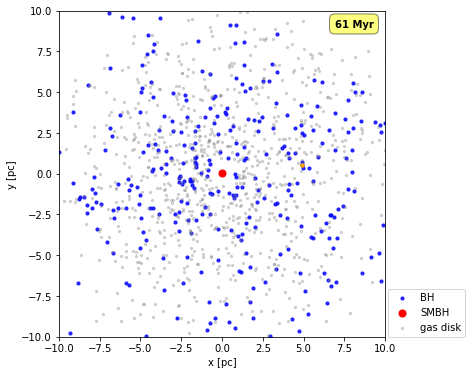



Evolved to t = 62 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 4.77526634524 d = 1557.37313767 au v = 8.66867129129 kms radius = 4.88921596165 parsec and theta_z = 0.238539712578


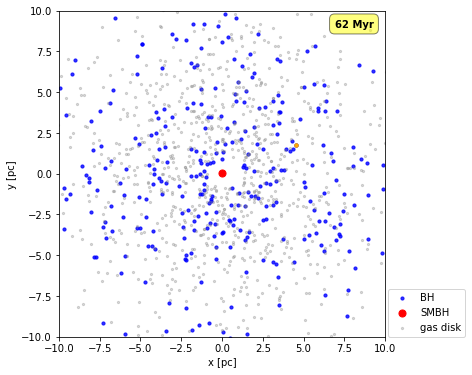



Evolved to t = 63 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 4.7788646616 d = 1630.83907659 au v = 8.1459259427 kms radius = 4.44909573555 parsec and theta_z = 0.220635937818


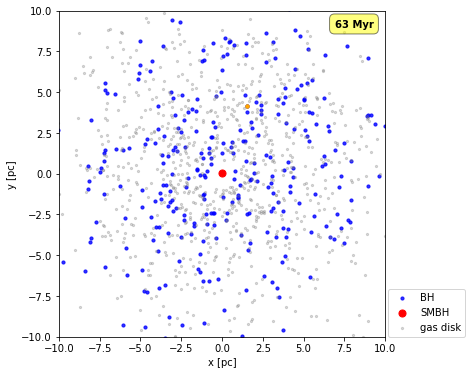



Evolved to t = 64 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 4.63091020095 d = 1612.70317981 au v = 8.2528125295 kms radius = 4.1519971329 parsec and theta_z = 0.224843558042


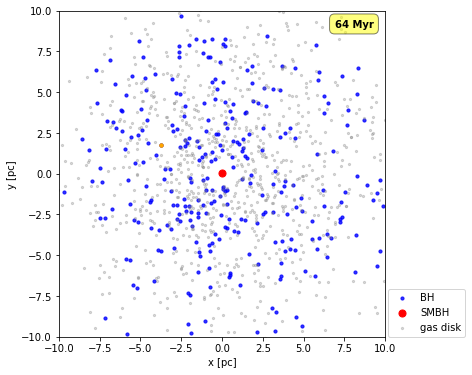



Evolved to t = 65 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.77817021228 d = 1383.25717789 au v = 9.90880947417 kms radius = 4.46012210997 parsec and theta_z = 0.219397183384


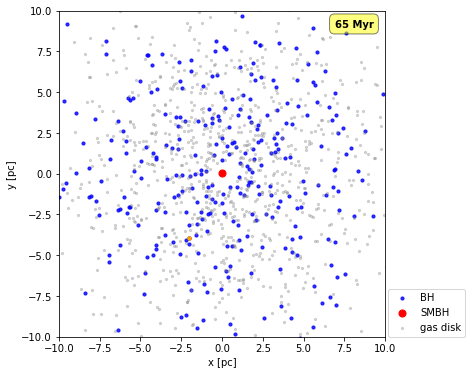



Evolved to t = 66 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.70621816065 d = 929.570100676 au v = 14.1889931759 kms radius = 4.8511856233 parsec and theta_z = 0.2248217337


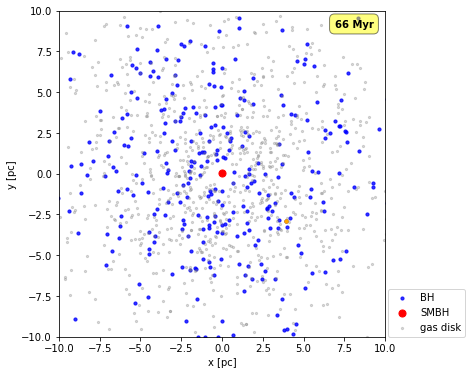



Evolved to t = 67 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.70098385178 d = 889.863844112 au v = 14.6719590955 kms radius = 4.78458683005 parsec and theta_z = 0.222396577598


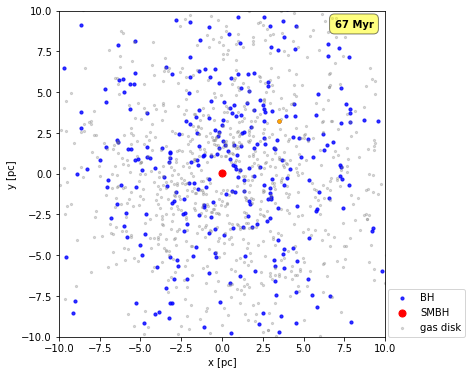



Evolved to t = 68 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH66' 'BH291'] with hardness = 4.87122667531 d = 1569.54041506 au v = 8.53017319517 kms radius = 4.2397924435 parsec and theta_z = 0.231533921921


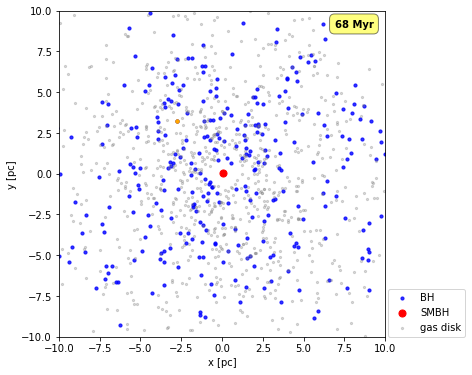



Evolved to t = 69 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.6586761291 d = 1874.3195406 au v = 6.53169416923 kms radius = 4.31113078065 parsec and theta_z = 0.232744780945


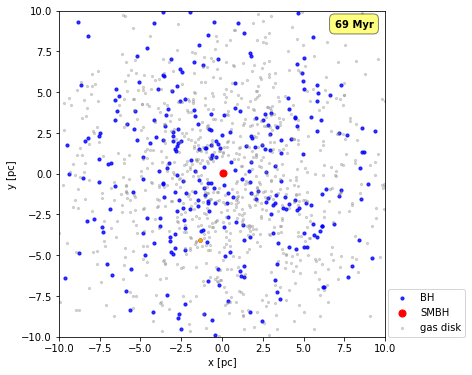



Evolved to t = 70 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.64469619666 d = 1990.1140234 au v = 5.80151114535 kms radius = 5.03624838051 parsec and theta_z = 0.252426593122


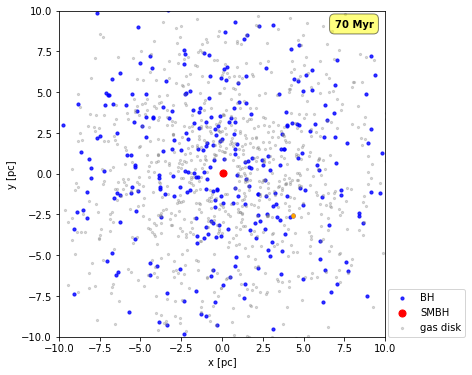



Evolved to t = 71 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.89349829222 d = 2086.74393394 au v = 5.06120742612 kms radius = 4.98610620152 parsec and theta_z = 0.331194232446


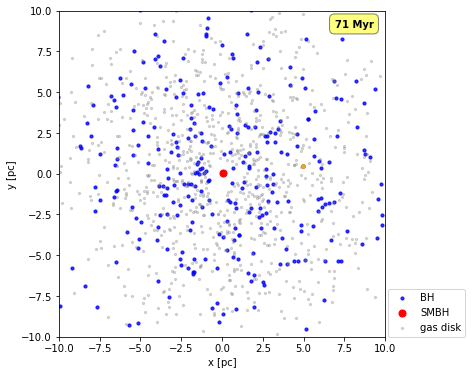



Evolved to t = 72 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.65762192258 d = 1807.0498764 au v = 6.86961361488 kms radius = 4.92727950051 parsec and theta_z = 0.365548767831


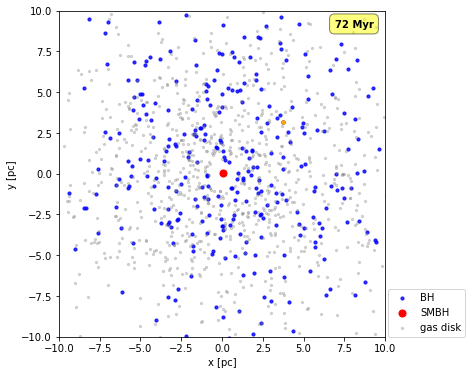



Evolved to t = 73 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.87638948009 d = 2243.58511262 au v = 3.94079575684 kms radius = 4.79655375164 parsec and theta_z = 0.425022405058


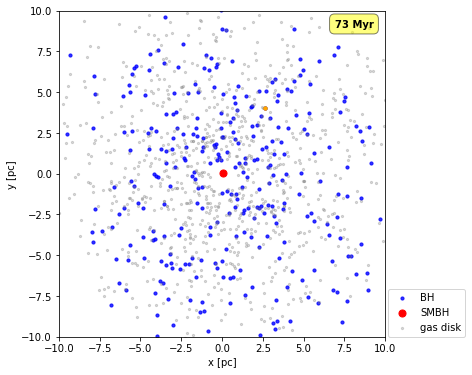



Evolved to t = 74 Myr 
BH number = 300
2 Binary found
Binary 1 is ['BH39' 'BH218'] with hardness = 0.732401763281 d = 5952.27263749 au v = 6.31926454864 kms radius = 3.92374864102 parsec and theta_z = -0.670188168561
Binary 2 is ['BH291' 'BH66'] with hardness = 4.80553500596 d = 2311.67193761 au v = 3.3914540252 kms radius = 4.76418143064 parsec and theta_z = 0.507665399933


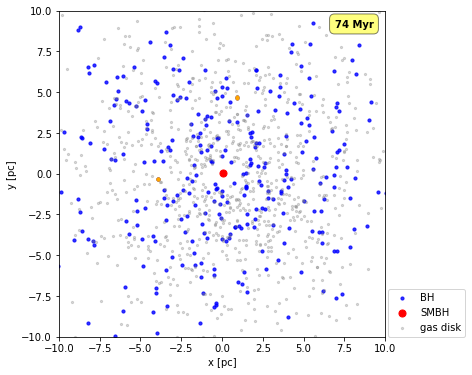



Evolved to t = 75 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.88079675462 d = 1037.7598368 au v = 12.9026734655 kms radius = 4.80938999682 parsec and theta_z = 0.609271476505


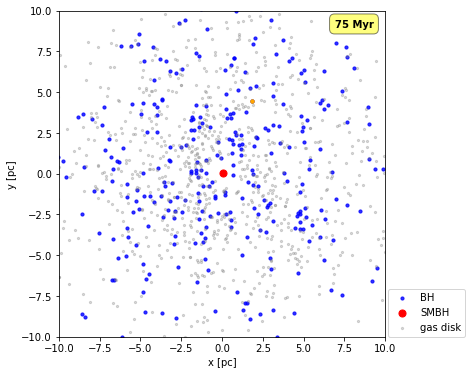



Evolved to t = 76 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.82325711978 d = 1235.45462186 au v = 11.0002384603 kms radius = 4.95361402959 parsec and theta_z = 0.705830687684


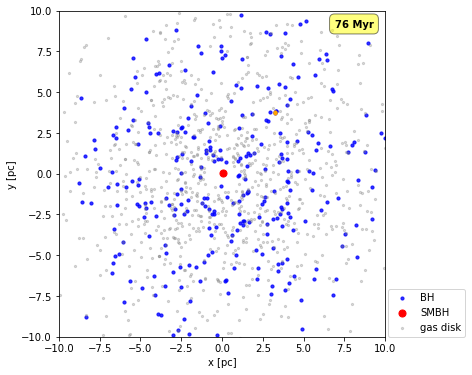



Evolved to t = 77 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.96535435309 d = 802.576053429 au v = 15.7504941294 kms radius = 5.10310672119 parsec and theta_z = 0.714959352527


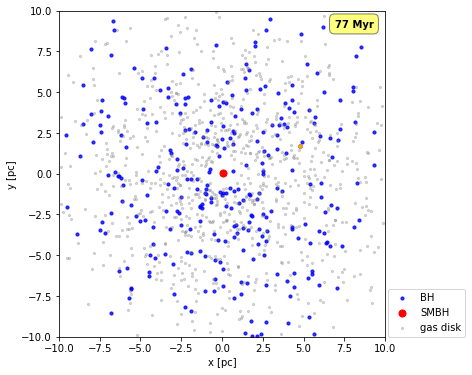



Evolved to t = 78 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.95471688964 d = 1890.28778932 au v = 6.16900074449 kms radius = 5.35525338412 parsec and theta_z = 0.629037886683


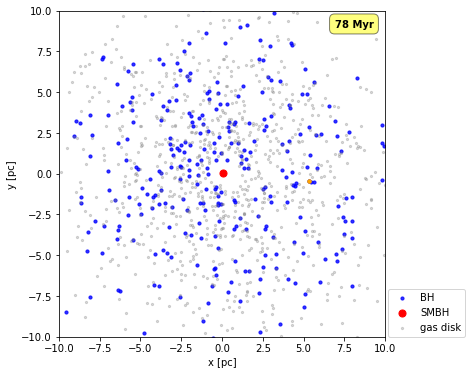



Evolved to t = 79 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH291' 'BH66'] with hardness = 4.83481346678 d = 1956.75323778 au v = 5.69652919635 kms radius = 5.23981198906 parsec and theta_z = 0.538526809522


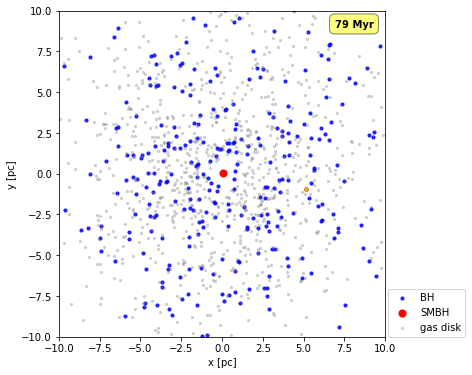

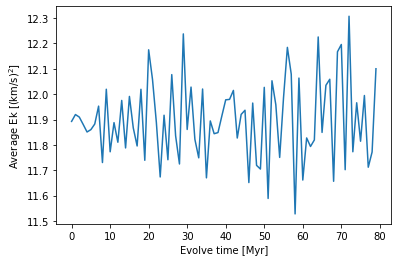

In [9]:
evolve_time_list_b = [] | units.Myr 
average_Ek_list_b = [] | units.kms**2

binary_b = []

bodies_x_b = []
bodies_y_b = []

model_time = 0 | units.Myr
time = [] | units.Myr
dt = 1e-2 | units.Myr
x = 0

# def gravity_hydro_bridge(gravityA, hydro, gravhydro, bodies, end_time):
        
gravity_initial_total_energy = gravityA.get_total_energy() + hydro.get_total_energy()

while model_time < end_time:    

    gravhydro.evolve_model(model_time)
    resolve_collision(stopping_condition, gravityA, Nbody) # Collision detection
        
    channel["to_BHs"].copy()
    channel["to_gasdisk"].copy()
        
    bodies_x_b.append(bodies.x.value_in(units.pc)) # Restore positions for animation
    bodies_y_b.append(bodies.y.value_in(units.pc))

    if model_time.value_in(units.Myr)>=x:
        x+=1
        print("Evolved to t =", int(model_time.number), "Myr",
                "\nBH number =", len(BHdisk))
            
        plot()
        scatter(gasdisk.x.value_in(units.pc), gasdisk.y.value_in(units.pc), s=5, alpha=0.3, c='gray', label="gas disk")
            
        b, average_Ek = get_binaries(Nbody) # Binaries detection
        
        if(len(b)>0):
            print(len(b), "Binary found")
            
            for i in range(len(b)):
                print("Binary", i+1, "is", b[i].name, "with hardness =", b[i].hardness[0], 
                      "d =", (b[i].position[0] - b[i].position[1]).length().in_(units.au),
                      "v =", (b[i].velocity[0] - b[i].velocity[1]).length().in_(units.kms),
                     "radius =", b[i].center_of_mass().length().in_(units.pc),
                     'and theta_z =', b[i].thetaz[0])
                
                binary_b.append([b[i].mass.sum().number, b[i].hardness[0], 
                                 (b[i].position[0] - b[i].position[1]).length().in_(units.au).number,
                               b[i].center_of_mass().length().in_(units.pc).number, b[i].thetaz[0],
                                (b[i].velocity[0] - b[i].velocity[1]).length().in_(units.kms).number])
                
                if b[i].hardness[0]<10:
                    scatter([b[i].x[0].value_in(units.pc), b[i].x[1].value_in(units.pc)], 
                                [b[i].y[0].value_in(units.pc), b[i].y[1].value_in(units.pc)], 
                                s=10, alpha=1, c='orange')
                else:
                    print("Here we have a hard binary!!!")
                    scatter([b[i].x[0].value_in(units.pc), b[i].x[1].value_in(units.pc)], 
                                [b[i].y[0].value_in(units.pc), b[i].y[1].value_in(units.pc)], 
                                s=10, alpha=1, c='g') 
                        
        plt.xlabel("x [pc]")
        plt.ylabel("y [pc]")
        plt.legend(bbox_to_anchor=(1.01, 0), loc=3, borderaxespad=0)
        plt.savefig(fig_root+''+str(int(model_time.value_in(units.Myr)))+'_Myr.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("\n")
            
        evolve_time_list_b.append(model_time)
        average_Ek_list_b.append(average_Ek)
        
    model_time += dt
        


gravityA.stop()
hydro.stop()

# end_time = 10 | units.Myr
# gravity_hydro_bridge(gravityA, hydro, gravhydro, 
#                      bodies, end_time)

plt.figure()
plt.plot(evolve_time_list_b.value_in(units.Myr), average_Ek_list_b.value_in(units.kms**2))
plt.xlabel('Evolve time [Myr]')
plt.ylabel('Average Ek [(km/s)$^2$]')
plt.savefig(fig_root+'average_Ek.png')
plt.show()

## Animation 

In [ ]:
# Animation for Nbody
import os
import matplotlib.animation as animation
from amuse.io import read_set_from_file

def animate(x, y):

    def update(i):
        while i >= n: i -= n
        off = []
        for j in range(len(x[i])):
            off.append([x[i][j],y[i][j]])
#             off.append(y[i][j])
#         off = np.array(off)
        scat.set_offsets(off)
        time.set_text(round(i*dt.value_in(units.Myr),2))
        return scat, time
    
    n = len(x)
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1,1,1)
    ax.set_xlim(-r, r)
    ax.set_ylim(-r, r)
    
    colormap = ['red']
    size = [50]
    edgecolor = ['orange']
    
    for i in range(1, len(x[0])):
        colormap.append('blue')
        size.append(10)
        edgecolor.append('blue')
        
    time = ax.annotate(0, xy=(7.5, 9.5), xytext=(7.5, 9.5), weight='heavy')
    scat = ax.scatter(x[0], y[0], c=colormap, s=size, edgecolor=edgecolor)
    anim = animation.FuncAnimation(fig, update, frames=1000, interval=50)
    plt.xlabel("x [pc]")
    plt.ylabel("y [pc]")
    ax.annotate("Myr", xy=(9, 9.5), xytext=(9, 9.5), weight='heavy')
    anim.save('figure/Nbody/animation.gif',writer='imagemagick',dpi=100,fps=30);

animate(bodies_x, bodies_y)

In [ ]:
# Animation for bridge
def animate_b(x, y):

    def update(i):
        while i >= n: i -= n
        off = []
        for j in range(len(x[i])):
            off.append([x[i][j],y[i][j]])
#             off.append(y[i][j])
#         off = np.array(off)
        scat.set_offsets(off)
        time.set_text(round(i*dt.value_in(units.Myr),2))
        return scat, time
    
    n = len(x)
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1,1,1)
    ax.set_xlim(-r, r)
    ax.set_ylim(-r, r)
    
    colormap = ['red']
    size = [50]
    edgecolor = ['orange']
    Alpha = [1]
    
    for i in range(1, len(BHdisk)+1):
        colormap.append('blue')
        size.append(10)
        edgecolor.append('blue')
        Alpha.append(1)
    for i in range(len(BHdisk)+1, len(bodies)):
        colormap.append('gray')
        size.append(10)
        edgecolor.append('gray')
        Alpha.append(0.3)
        
    time = ax.annotate(0, xy=(7.5, 9.5), xytext=(7.5, 9.5), weight='heavy')
    scat = ax.scatter(x[0], y[0], c=colormap, s=size, edgecolor=edgecolor, alpha=Alpha)
    anim = animation.FuncAnimation(fig, update, frames=1000, interval=50)
    plt.xlabel("x [pc]")
    plt.ylabel("y [pc]")
    ax.annotate("Myr", xy=(9, 9.5), xytext=(9, 9.5), weight='heavy')
    anim.save('figure/Bridge/animation.gif',writer='imagemagick',dpi=100,fps=30);

animate_b(bodies_x_b, bodies_y_b)

## Analysis

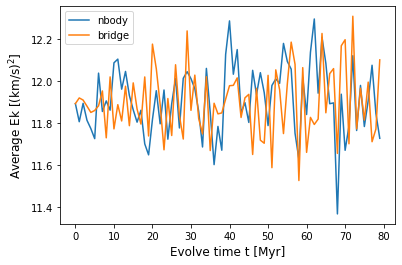

In [12]:
# Compare average kinetic energy
plt.figure()
plt.plot(evolve_time_list.value_in(units.Myr), average_Ek_list.value_in(units.kms**2), label="nbody")
plt.plot(evolve_time_list_b.value_in(units.Myr), average_Ek_list_b.value_in(units.kms**2), label="bridge")
plt.xlabel('Evolve time t [Myr]',fontsize=12)
plt.ylabel('Average Ek [(km/s)$^2$]',fontsize=12)
plt.legend(loc='best')
plt.savefig('figure/average_Ek of Nbody and Bridge simulation.png')
plt.show()

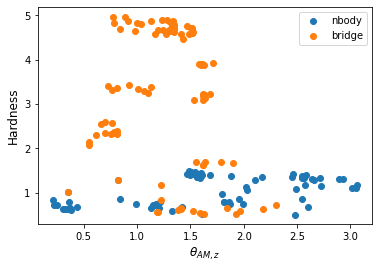

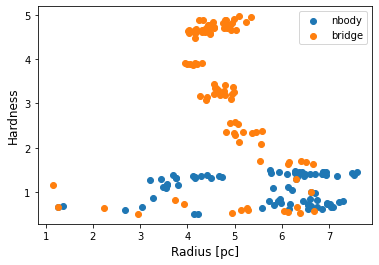

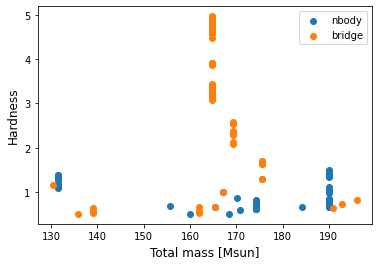

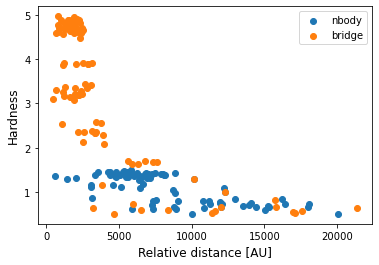

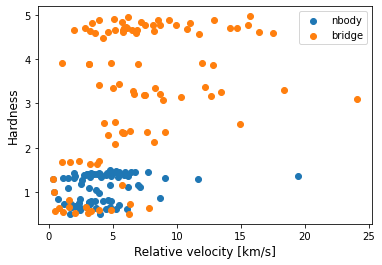

In [39]:
# Binary properties
binary_n = np.array(binary_n)
binary_b = np.array(binary_b)
mass_n, mass_b = binary_n[:,0], binary_b[:,0]
hardness_n, hardness_b = binary_n[:,1], binary_b[:,1]
d_n, d_b = binary_n[:,2], binary_b[:,2]
radius_n, radius_b = binary_n[:,3], binary_b[:,3]
thetaz_n, thetaz_b = binary_n[:,4], binary_b[:,4]
v_n, v_b = binary_n[:,5], binary_b[:,5]

plt.figure()
scatter(np.arccos(thetaz_n), hardness_n, label="nbody")
scatter(np.arccos(thetaz_b), hardness_b, label="bridge")
plt.xlabel(r'$\theta_{AM, z}$', fontsize=12)
plt.ylabel('Hardness',fontsize=12)
plt.legend(loc='best')
plt.savefig('figure/hardness vs. thetaz of binaries.png')
plt.show()

plt.figure()
scatter(radius_n, hardness_n, label="nbody")
scatter(radius_b, hardness_b, label="bridge")
plt.xlabel('Radius [pc]',fontsize=12)
plt.ylabel('Hardness',fontsize=12)
plt.legend(loc='best')
plt.savefig('figure/hardness vs. orbital radius of binaries.png')
plt.show()

plt.figure()
scatter(mass_n, hardness_n, label="nbody")
scatter(mass_b, hardness_b, label="bridge")
plt.xlabel('Total mass [Msun]',fontsize=12)
plt.ylabel('Hardness',fontsize=12)
plt.legend(loc='best')
plt.savefig('figure/hardness vs. total mass of binaries.png')
plt.show()

plt.figure()
scatter(d_n, hardness_n, label="nbody")
scatter(d_b, hardness_b, label="bridge")
plt.xlabel('Relative distance [AU]',fontsize=12)
plt.ylabel('Hardness',fontsize=12)
plt.legend(loc='best')
plt.savefig('figure/hardness vs. relative distance of binaries.png')
plt.show()

plt.figure()
scatter(v_n, hardness_n, label="nbody")
scatter(v_b, hardness_b, label="bridge")
plt.xlabel('Relative velocity [km/s]',fontsize=12)
plt.ylabel('Hardness',fontsize=12)
plt.legend(loc='best')
plt.savefig('figure/hardness vs. relative velocity of binaries.png')
plt.show()

In [16]:
print("Nbody soft/hard binaries number in", end_time, "is", len(binary_n))
print("Bridge soft/hard binaries number in", end_time, "is", len(binary_b))

Nbody soft/hard binaries number in 80 Myr is 81
Bridge soft/hard binaries number in 80 Myr is 96


In [59]:
BH_init = []
for i in range(len(BHdisk0)):
    BH_init.append([BHdisk0.mass[i].value_in(units.MSun), BHdisk0.name[i], BHdisk0.radius[i].value_in(units.m),
                   BHdisk0.vx[i].value_in(units.kms),BHdisk0.vy[i].value_in(units.kms),BHdisk0.vz[i].value_in(units.kms),
                   BHdisk0.x[i].value_in(units.pc),BHdisk0.y[i].value_in(units.pc),BHdisk0.z[i].value_in(units.pc)])
    
BH_init = np.array(BH_init)
np.savetxt("BH_init.txt", BH_init, fmt='%s', delimiter=',')

import os
with open('BH_init.txt', 'r+') as f:
 content = f.read()  
 f.seek(0, 0)
 f.write('#mass/MSun,name,radius/m,vx/kms,vy/kms,vz/kms,x/pc,y/pc,z/pc\n'+content)